# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf). 

Link to help create a table of contents is [here](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html).

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sleep Sensitivity
In this notebook we take a look at the variables that might be affecting sleep the most.

In [78]:
import os
import sys
sys.path.append('../src')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
    1. [Labels](#labels)
    2. [Features](#features)
        1. Complete
        2. Home Environment Survey
        2. IEQ
        3. Mood
        4. Self-Report Sleep
        5. Fitbit Activity
2. [Pre-Processing](#preprocessing)
    1. [Target Data](#target_data)
        1. Summary
        1. Scaling and Normalization
        2. Clustering
    2. [Feature Data](#feature_data)
        1. IEQ
        2. Mood
        3. Self-Report Sleep
        4. Fitbit Activity
        5. Dropping ID and Timestamp Columns
3. [Feature Engineering](#feature_engineering)
    1. [Mutual Information - Aggregate Level](#mutual_information_aggregate)
    2. [Mutual Information - Individual Level](#mutual_information_individual)
    2. [Clustering](#clustering)
    3. [Principal Component Analysis](#pca)

In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

<a id='data_import'></a>

# Data Import
We have a spate of data available to us from the three main modalities: beacon, Fitbit, and Beiwe. Each of these datasets can be analyzed individually or all together. Each of these datasets has already been created via the `build_features` source code.

<a id='labels'></a>

## Labels
We can start by importing the labels dataset: Fitbit sleep metrics.

In [4]:
labels = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
labels.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb
count,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3345.000000,1724.000000,3504.000000,3504.00000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000
mean,3.732877,78.116438,28.628425,243.468322,9.700057,88.055936,30.985445,64.426370,86.464991,45.894170,21.473898,32.361301,321.58476,0.278173,6.827345,0.213224,0.786776,55.678368,5.012272,3.735731
std,1.472555,26.123657,8.734747,55.922626,4.415598,31.092768,9.535310,20.038907,3.087718,24.724623,11.936372,9.421136,63.71715,0.095474,1.323325,0.059408,0.059408,20.631031,6.136670,6.158467
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,71.003717,0.000000,1.000000,5.000000,116.00000,0.000000,2.550000,0.000000,0.562300,5.000000,0.000000,0.000000
25%,3.000000,61.000000,23.000000,208.000000,6.000000,67.750000,25.000000,51.000000,84.496623,29.000000,13.000000,26.000000,285.00000,0.214286,6.095833,0.176471,0.744946,41.500000,0.500000,0.000000
50%,4.000000,78.000000,28.000000,242.000000,9.000000,89.000000,31.000000,63.000000,86.699188,47.000000,21.000000,32.000000,324.00000,0.277690,6.900000,0.217338,0.782662,54.500000,3.500000,0.000000
75%,5.000000,95.000000,34.000000,278.000000,12.000000,109.000000,37.000000,76.000000,88.616169,64.000000,29.000000,39.000000,361.00000,0.342379,7.650000,0.255054,0.823529,68.500000,8.000000,6.000000
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,75.000000,200.000000,95.238095,90.000000,46.000000,69.000000,775.00000,0.778409,14.783333,0.437700,1.000000,199.500000,56.500000,56.000000


<a id='features'></a>

In [5]:
n_nights = labels["redcap"].value_counts().values
np.percentile(n_nights,25)

23.0

## Features
Next we can import the various datasets that can be used for the features. We start with the most complete dataset and trickle down from there.

### Complete Features Dataset
This dataset, while short, is the most comprehensive and includes overlapping data from all modalities.

In [6]:
features_complete = pd.read_csv("../data/processed/all_modalities-fb_and_gps_filtered-ux_s20.csv",parse_dates=["start_time","end_time"])
features_complete.describe()

,lat_mean,long_mean,altitude_mean,accuracy_mean,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,lat_median,long_median,altitude_median,accuracy_median,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,lat_delta,long_delta,altitude_delta,accuracy_delta,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,lat_delta_percent,long_delta_percent,altitude_delta_percent,accuracy_delta_percent,tvoc_delta_percent,lux_delta_percent,no2_delta_percent,co_delta_percent,co2_delta_percent,pm1_number_delta_percent,pm2p5_number_delta_percent,pm10_number_delta_percent,pm1_mass_delta_percent,pm2p5_mass_delta_percent,pm10_mass_delta_percent,temperature_c_delta_percent,rh_delta_percent,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,13.000000,27.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,13.000000,27.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,13.000000,27.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,18.000000,13.000000,27.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,27.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,31.651653,-97.373570,200.888521,202.967978,251.712298,7.032569,1.114077,2.768048,963.774649,6.996908,7.361433,7.404706,0.533195,3.625838,2.183347,26.741380,42.517186,23.250000,28.214286,43.642857,31.651632,-97.373458,201.768912,44.877795,247.515278,3.160009,1.122155,2.695098,958.880411,6.728479,7.134359,7.185406,0.519860,3.544788,2.171793,26.721875,42.458929,0.002387,0.004289,10.523620,2446.377347,186.429167,40.625289,0.166649,1.550709,218.413666,7.797990,8.249248,8.306266,0.536028,5.044849,0.985658,1.334524,3.243750,0.007355,-0.004420,6.105896,44460.462467,inf,inf,37.581537,inf,28.707581,935.822231,3044.823036,2076.355929,349.519575,358.309482,56.032447,5.263338,7.834223,2.428571,0.629630,0.107143,0.071429,2.392857,6.714286,13.500000,1.892857,2.250000,2.392857,0.500000,0.178571,0.071429,2.357143,2130.750000,7804.142857,3.350394,709.642857,194.142857,15.428571,25.607143,869.714286,3.964286,75.821429,27.821429,241.107143,8.571429,77.571429,29.500000,60.571429,86.748226,31.785714,316.928571,0.244144,6.575000,0.193601,0.806399,52.160714,4.625000,3.785714
std,1.502767,0.487819,57.348595,187.277738,83.889905,21.135152,0.258124,2.643863,294.731746,4.521898,4.547876,4.510808,0.288385,1.765721,0.248282,1.985920,5.497522,11.390786,13.062123,18.088700,1.502736,0.487866,57.743756,23.922777,90.3

### Home Environment Survey
The Home Environment Survey contains information regarding the environment that each participant lived in which could be cross-referenced with the Fitbit sleep data.

In [7]:
features_env = pd.read_csv("../data/processed/redcap_fitbit-environment_and_sleep-ux_s20.csv",
                           dtype={"window_use":object,"cleaner":object,"cleaner_locations":object},parse_dates=["start_date","end_date","start_time","end_time"])
features_env.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,building_type,change_temperature,fresh_air,both,other_window_use,no_window_use,stagnant,smelly,earthy,moldy,cooking,fragrant,well_ventilated,obnoxious,other_smell,no_smell,allergy_intensity,bleach,ammonia,pinesol,vinegar,alcohol,disinfectant_wipes,soap_and_water,floor_cleaners,no_cleaners,cleaner_locations,fitbit
0,2020-05-20,2020-05-20,2,33,22,246,9,56,29,63,8vpj3b9v,84.170854,2020-05-20 07:44:00,2020-05-20 01:05:30,14.0,NaN,24,279,0.200717,5.583333,0.167164,0.832836,62.5,0.5,0.0,house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'bleach': [], 'ammonia': [], 'pinesol': [], '...",26.0
1,2020-05-30,2020-05-30,4,44,21,203,5,46,21,56,8vpj3b9v,83.954155,2020-05-30 09:34:00,2020-05-30 03:44:30,14.0,NaN,25,247,0.186235,4.883333,0.156997,0.843003,49.0,0.5,6.5,house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'bleach': [], 'ammonia': [], 'pinesol': [], '...",26.0
2,2020-06-01,2020-06-01,3,72,20,270,12,101,28,73,8vpj3b9v,85.852713,2020-06-01 11:09:30,2020-06-01 02:33:30,14.0,NaN,23,342,0.295322,7.383333,0.227991,0.772009,58.5,7.0,7.5,house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'bleach': [], 'ammonia': [], 'pinesol': [], '...",26.0
3,2020-06-02,2020-06-02,3,95,19,194,16,97,28,38,8vpj3b9v,91.037736,2020-06-02 09:40:00,2020-06-02 02:36:00,14.0,NaN,22,289,0.335640,6.433333,0.251295,0.748705,32.0,6.0,0.0,house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'bleach': [], 'ammonia': [], 'pinesol': [], '...",26.0
4,2020-06-03,2020-06-03,3,62,26,246,17,109,32,54,8vpj3b9v,88.535032,2020-06-03 10:36:00,2020-06-03 02:44:30,14.0,NaN,29,308,0.353896,6.950000,0.261391,0.738609,54.0,0.0,0.0,house,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"{'bleach': [], 'ammonia': [], 'pinesol': [], '...",26.0


In [8]:
print("Number of participants:", len(features_env["beiwe"].unique()))

Number of participants: 40


### IEQ Features Dataset
Arguably the most restrictive dataset after the complete set, we can import the IEQ features from the beacon. We have to do a little pre-processing first to remove the GPS features and any column that ends with "percent" since these data are bad. 

In [9]:
ieq_data = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
features_ieq = ieq_data.merge(right=labels,left_on=["start_time","end_time","beacon","redcap","beiwe"],right_on=["start_time","end_time","beacon","redcap","beiwe"])
features_ieq.drop([c for c in features_ieq.columns if c.endswith("percent")],axis="columns",inplace=True)
for gps_label in ["long","lat","accuracy","altitude"]:
    features_ieq.drop([c for c in features_ieq.columns if c.startswith(gps_label)],axis="columns",inplace=True)
features_ieq.dropna(subset=["tvoc_mean"],inplace=True)
features_ieq.describe()

,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,nrem_minutes,rem2nrem,tst_fb,waso,sol_fb,wol_fb
count,280.000000,278.000000,134.000000,274.000000,280.000000,267.000000,267.000000,267.000000,267.000000,260.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,278.000000,134.000000,274.000000,280.000000,267.000000,267.000000,267.000000,267.000000,260.000000,280.000000,280.000000,280.000000,280.000000,278.000000,134.000000,274.000000,280.000000,267.000000,267.000000,267.000000,267.000000,260.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,263.823647,5.946822,1.171628,2.737799,974.304506,8.265665,8.567762,8.587901,0.605463,4.026538,2.135080,26.922953,42.378647,24.171429,30.689286,43.046429,256.740079,3.057975,1.172192,2.703967,971.102965,7.844398,8.174135,8.198004,0.580299,3.864662,2.118186,26.929033,42.311984,197.001508,29.383679,0.134684,1.143856,193.982784,9.797681,10.067115,10.071055,0.653079,6.024319,0.977563,1.189216,3.223442,3.525000,74.132143,27.050000,244.242857,9.060714,82.092857,29.246429,59.996429,86.989353,30.575000,318.375000,0.259138,6.674464,51.925000,4.650000,3.421429
std,137.823126,20.922371,0.284076,2.469508,517.815284,8.931949,8.706834,8.577903,0.548952,3.333742,0.551659,1.892954,5.475180,11.811205,12.790841,16.861272,136.820373,8.647193,0.287441,2.457594,520.017863,8.371646,8.212035,8.113071,0.517701,3.115454,0.545905,1.907794,5.387791,256.902551,155.273525,0.171226,1.454638,156.021426,14.691828,13.519934,13.117591,0.908957,8.959897,0.765176,0.757709,2.237353,1.383239,27.627717,7.954463,54.177773,4.244316,30.860629,8.322358,18.388187,2.933078,8.709247,60.493005,0.091291,1.306610,18.941754,5.779924,5.553671
min,19.016547,0.000000,0.716650,0.000544,429.603078,0.116044,0.469432,0.598738,0.088306,1.015004,0.546604,22.535969,31.449031,1.000000,9.000000,10.000000,9.500000,0.000000,0.704758,0.000525,426.243622,0.116044,0.469432,0.598738,0.080327,0.952144,0.546604,22.500000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,88.000000,0.000000,0.000000,7.000000,16.000000,74.095238,10.000000,127.000000,0.000000,2.550000,6.500000,0.000000,0.000000
25%,193.707639,0.000000,0.989857,1.143780,732.711164,2.869419,2.970114,3.052139,0.272980,1.942168,1.928358,25.387933,38.958874,17.000000,16.000000,36.000000,186.862500,0.000000,0.986901,1.117450,730.713995,2.669085,2.872435,2.888888,0.253918,1.856033,1.914521,25.087500,38.987500,87.512500,0.000000,0.035609,0.488604,96.165065,3.451684,4.081318,4.192919,0.275464,2.723520,0.605640,0.950000,2.000000,3.000000,55.750000,22.000000,215.750000,6.000000,63.750000,24.000000,48.000000,85.063455,25.000000,286.000000,0.203883,6.095833,38.875000,0.000000,0.000000
50%,241.903841,0.429269,1.088618,2.429130,862.509546,6.447137,6.889388,6.923988,0.485156,3.232512,2.076789,27.047065,41.402084,22.500000,37.000000,42.000000,237.100000,0.000000,1.087990,2.379833,860.684524,6.276052,6.645753,6.691255,0.480064,3.118307,2.060321,27.000000,41.479167,135.775000,2.040000,0.065026,0.829467,164.117869,5.736758,6.314100,6.400458,0.411972,4.359458,0.885618,1.000000,2.708333,3.000000,76.0

### Self-Report Mood Features Dataset
A more complex relationship

In [10]:
features_mood = pd.read_csv("../data/processed/beiwe_fitbit-evening_mood_and_sleep-ux_s20.csv",parse_dates=["start_date","end_date","start_time","end_time"])
features_mood.dropna(subset=["content","sad","lonely","stress","energy"],inplace=True)
for mood in ["content","sad","lonely","stress","energy"]:
    features_mood[mood] = features_mood[mood].astype(int,errors="raise") 
features_mood.dtypes

start_date       datetime64[ns]
end_date         datetime64[ns]
deep_count                int64
deep_minutes              int64
light_count               int64
light_minutes             int64
rem_count                 int64
rem_minutes               int64
wake_count                int64
wake_minutes              int64
beiwe                    object
efficiency              float64
end_time         datetime64[ns]
start_time       datetime64[ns]
redcap                  float64
beacon                  float64
nrem_count                int64
nrem_minutes              int64
rem2nrem                float64
tst_fb                  float64
rem_percent             float64
nrem_percent            float64
waso                    float64
sol_fb                  float64
wol_fb                  float64
timestamp                object
content                   int64
stress                    int64
lonely                    int64
sad                       int64
energy                    int64
dtype: o

In [11]:
print("Number of participants:", len(features_mood["beiwe"].unique()))

Number of participants: 44


### Self-Report Sleep Metric (SRSM) Features Dataset
The feature set that should have the greatest relationship with the Fitbit since it is another measure of sleep quality. 

In [12]:
features_srsm = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_srsm.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,tst_ema,sol_ema,naw_ema,restful_ema
count,1060.000000,1060.000000,1060.000000,1060.00000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,674.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000,1060.000000
mean,3.644340,76.657547,28.851887,246.04434,9.743396,87.232075,31.242453,63.796226,86.584780,45.759434,20.841246,32.496226,322.701887,0.273547,6.832233,0.210638,0.789362,54.783962,5.062736,3.949528,6.978632,18.348585,1.654717,2.007547
std,1.402452,25.495073,8.510159,56.05229,4.707317,31.156265,9.539080,19.407123,2.934535,23.881389,11.235558,9.136825,62.107432,0.091556,1.305324,0.058111,0.058111,19.450162,6.360330,6.205525,1.294057,21.295849,1.601942,0.767579
min,0.000000,0.000000,7.000000,87.00000,0.000000,0.000000,5.000000,16.000000,73.461538,0.000000,1.000000,9.000000,126.000000,0.000000,2.650000,0.000000,0.628931,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,61.000000,23.000000,208.00000,6.000000,65.000000,25.000000,51.000000,84.863951,29.000000,13.000000,26.000000,285.000000,0.212929,6.083333,0.175550,0.746819,42.500000,0.000000,0.000000,6.000000,10.000000,1.000000,2.000000
50%,4.000000,76.000000,28.000000,243.00000,9.000000,88.000000,31.000000,62.000000,86.717705,47.000000,21.000000,32.000000,324.000000,0.275733,6.866667,0.216137,0.783863,53.500000,1.000000,0.000000,7.000000,15.000000,1.000000,2.000000
75%,4.250000,94.000000,34.250000,281.00000,13.000000,108.000000,37.000000,75.000000,88.619941,62.000000,29.000000,39.000000,362.000000,0.339012,7.633333,0.253181,0.824450,66.000000,8.000000,6.500000,8.000000,20.000000,2.000000,3.000000
max,9.000000,148.000000,61.000000,470.00000,26.000000,209.000000,63.000000,145.000000,94.166667,90.000000,44.000000,66.000000,574.000000,0.590000,12.483333,0.371069,1.000000,144.500000,35.000000,39.500000,12.000000,240.000000,15.000000,3.000000


### Fitbit Activity Features Dataset
The largest and final features set is the activity data from Fitbit which should be the closest match to all Fitbit sleep data we have since both are collected from the same source.

In [13]:
features_activity = pd.read_csv("../data/processed/fitbit_fitbit-daily_activity_and_sleep-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_activity.drop(["water_logged","food_calories_logged","fat","bmr","bmi","weight"],axis="columns",inplace=True)
features_activity.dtypes

start_date                  datetime64[ns]
end_date                    datetime64[ns]
deep_count                           int64
deep_minutes                         int64
light_count                          int64
light_minutes                        int64
rem_count                            int64
rem_minutes                          int64
wake_count                           int64
wake_minutes                         int64
beiwe                               object
efficiency                         float64
end_time                    datetime64[ns]
start_time                  datetime64[ns]
redcap                             float64
beacon                             float64
nrem_count                           int64
nrem_minutes                         int64
rem2nrem                           float64
tst_fb                             float64
rem_percent                        float64
nrem_percent                       float64
waso                               float64
sol_fb     

<a id='preprocessing'></a>

In [14]:
print("Number of participants:", len(features_activity["beiwe"].unique()))

Number of participants: 52


# Pre-Processing
The analysis section is outlined as followed:

- [Target Data](#target_data)
- [Feature Data](#feature_data)

Much of this code has been refractured into the `processing` source code and we import that module below so that we can simplify the code presented in this notebook.

In [15]:
from src.processing import process
# defining feature engineering object
pp = process.preprocess()

<a id='target_data'></a>

## Target Data
Since the feature sets are all corroborated against the Fitbit sleep data, there won't be any missing data values so we don't have to worry about filling in any gaps.

The general outline is as follows:

- [Summary](#summary)
- [Scaling and Normalizing](#scaling)
- [Clustering](#clustering)

<a id='summary'></a>

### Summary
Here we look at summarizing data and figures to get a sense of the target data we are considering. We will start by removing some columns that are not necessary for analysis.

In [16]:
targets = labels.drop(['start_date','end_date','start_time','end_time','beiwe','end_time','redcap','beacon'],axis="columns",errors="ignore")
targets.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb
count,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.00000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000
mean,3.732877,78.116438,28.628425,243.468322,9.700057,88.055936,30.985445,64.426370,86.464991,32.361301,321.58476,0.278173,6.827345,0.213224,0.786776,55.678368,5.012272,3.735731
std,1.472555,26.123657,8.734747,55.922626,4.415598,31.092768,9.535310,20.038907,3.087718,9.421136,63.71715,0.095474,1.323325,0.059408,0.059408,20.631031,6.136670,6.158467
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,71.003717,5.000000,116.00000,0.000000,2.550000,0.000000,0.562300,5.000000,0.000000,0.000000
25%,3.000000,61.000000,23.000000,208.000000,6.000000,67.750000,25.000000,51.000000,84.496623,26.000000,285.00000,0.214286,6.095833,0.176471,0.744946,41.500000,0.500000,0.000000
50%,4.000000,78.000000,28.000000,242.000000,9.000000,89.000000,31.000000,63.000000,86.699188,32.000000,324.00000,0.277690,6.900000,0.217338,0.782662,54.500000,3.500000,0.000000
75%,5.000000,95.000000,34.000000,278.000000,12.000000,109.000000,37.000000,76.000000,88.616169,39.000000,361.00000,0.342379,7.650000,0.255054,0.823529,68.500000,8.000000,6.000000
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,75.000000,200.000000,95.238095,69.000000,775.00000,0.778409,14.783333,0.437700,1.000000,199.500000,56.500000,56.000000


#### Distributions

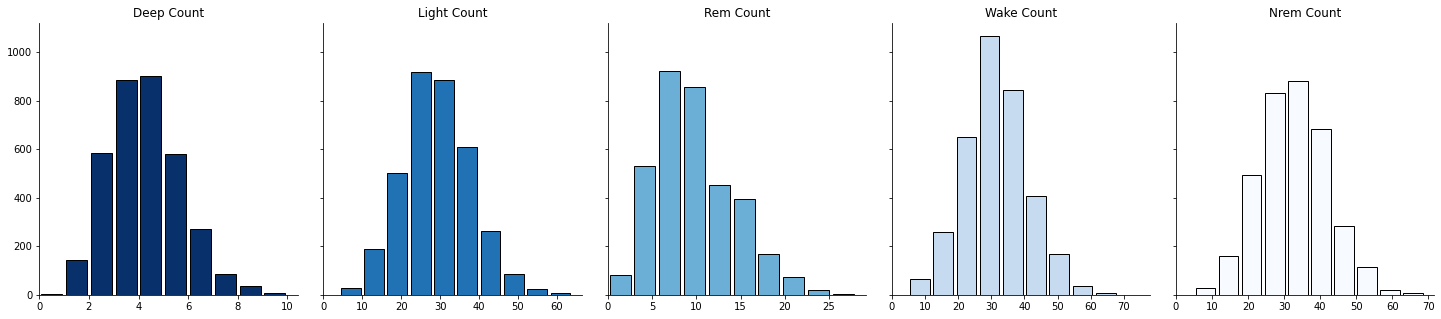

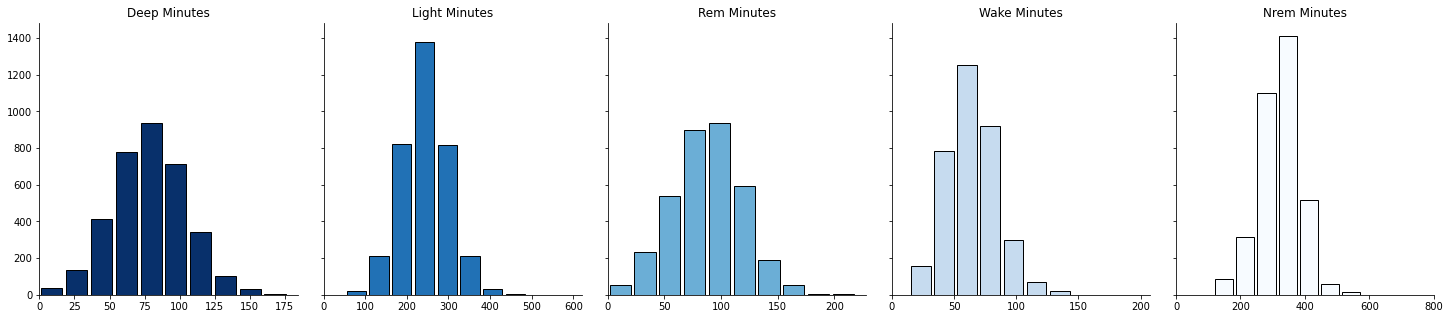

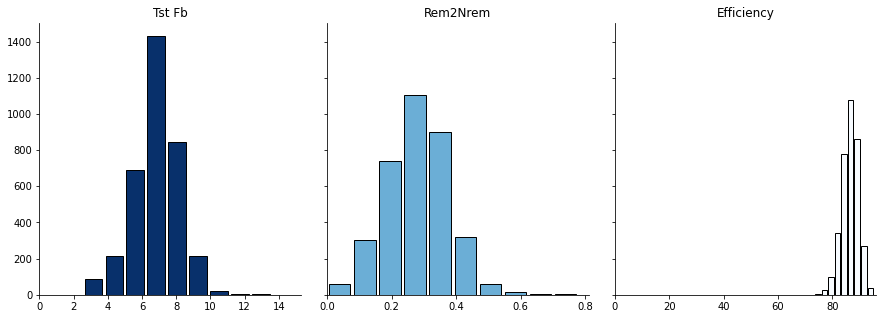

In [18]:
# Count metrics
sm_count = targets[[column for column in targets.columns if column.endswith("count") and "2" not in column]]
pp.plot_hist(sm_count)
# Minute metrics
sm_minutes = targets[[column for column in targets.columns if column.endswith("minutes") and "2" not in column]]
pp.plot_hist(sm_minutes)
# Other metrics
sm = targets[["tst_fb","rem2nrem","efficiency"]]
pp.plot_hist(sm)

<div class="alert alert-block alert-info">
    
Remarkably all but one of the sleep metric targets are normally distributed. The only metric that is not is `efficiency` which is _heavily_ skewed towards higher values, but we can try normalizing the efficiency values to use as a target instead.
    
</div>

<a id="scaling"></a>

### Scaling and Normalizing
There are a few datasets that could use some scaling, primarily those datasets that show `minutes` and the `efficiency` target. Below we can try a few methods to deal with these data.

#### Scaling
Data recorded as minutes spent in different stages should be scaled based on the TST for that night since time spent in sleep stages is dependent on the time one is asleep. However this is not scaling in a traditional sense, but more of a _target engineering_.

In [19]:
for column in targets.columns:
    if column.endswith("minutes"):
        variable = column.split("_")[0]
        if variable not in ["rem2nrem"]:
            targets[variable+"_percent"] = targets[column] / (targets["tst_fb"]*60) * 100
            targets.drop(column,axis="columns",inplace=True)
        
targets["rem2nrem_percent"] = targets["rem_percent"] / targets["nrem_percent"]
targets.head()

,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem,tst_fb,rem_percent,nrem_percent,waso,sol_fb,wol_fb,deep_percent,light_percent,wake_percent,rem2nrem_percent
0,5,20,10,21,93.349754,25,0.276094,6.316667,21.635884,78.364116,18.5,8.5,0.0,22.163588,56.200528,7.124011,0.276094
1,4,31,6,33,79.513185,35,0.136232,6.533333,11.989796,88.010204,68.5,0.0,32.5,24.234694,63.775510,25.765306,0.136232
2,2,17,8,20,87.234043,19,0.210970,4.783333,17.421603,82.578397,19.5,11.5,11.0,16.376307,66.202091,14.634146,0.210970
3,5,21,11,25,90.156600,26,0.259375,6.716667,20.595533,79.404467,23.0,12.5,8.5,19.354839,60.049628,10.918114,0.259375
4,5,20,14,28,84.375000,25,0.334601,5.850000,25.071225,74.928775,53.5,11.5,0.0,27.350427,47.578348,18.518519,0.334601


Now we can check the distributions again

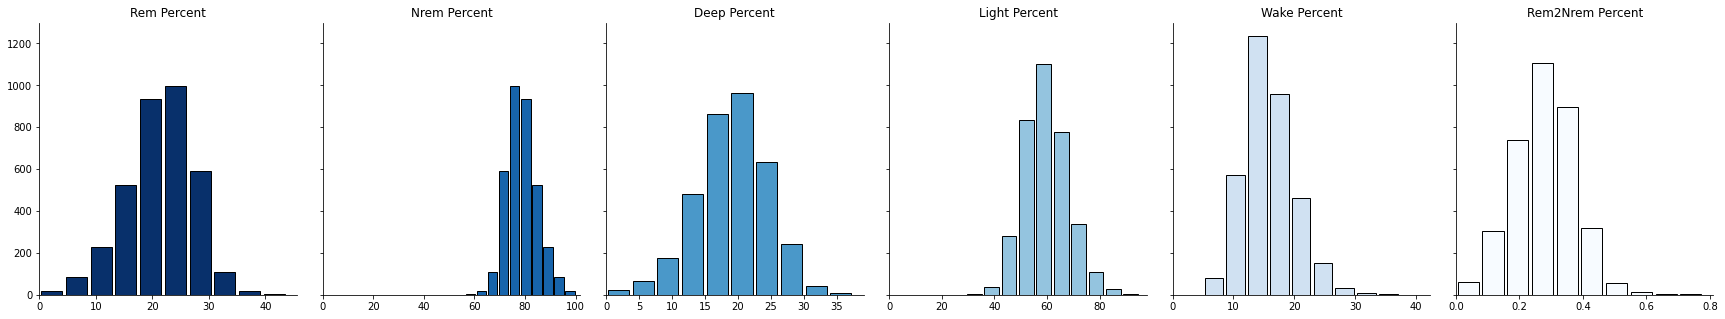

In [20]:
# Percent metrics
sm_percent = targets[[column for column in targets.columns if column.endswith("percent")]]
pp.plot_hist(sm_percent)

<div class="alert alert-block alert-info">
    
Targets are still normally distributed but now with some noteable outliers.
    
</div>

In [21]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, features_env]
for dataset in datasets:
    for column in dataset.columns:
        if column.endswith("minutes") and column not in ["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]:
            variable = column.split("_")[0]
            if variable not in ["rem2nrem"]:
                dataset[variable+"_percent"] = dataset[column] / (dataset["tst_fb"]*60) * 100
                dataset.drop(column,axis="columns",inplace=True)

    dataset["rem2nrem_percent"] = dataset["rem_percent"] / dataset["nrem_percent"]

#### Normalizing
There is little to no need to normalize the sleep metrics other than `efficiency`, but the code is generalized in case we want to go back.

##### Target: Efficiency

The `process` module has a function to normalize the data:

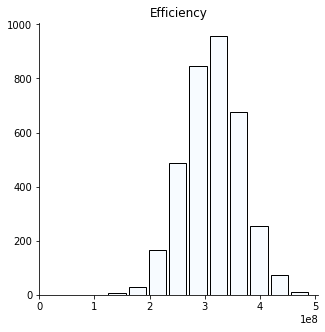

In [22]:
normalized_efficiency_only = pp.normalize(targets[["efficiency"]])
pp.plot_hist(normalized_efficiency_only)

The normalization has _dramatically_ increased the values of our data which might not make it an appropriate application. The cell below creates a new column in each of the feature sets with this normalized efficiency.

In [23]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    dataset["efficiency_normalized"] = pp.normalize(dataset[["efficiency"]]) # adding normalized efficiency to feature sets

### Clustering
Clustering might be the most appropriate technique to separate the `efficiency` target. Additionally, there might be a need to cluster the sleep times since we do seem to have a few outliers. 

In [24]:
from sklearn.cluster import KMeans

##### Target: Efficiency

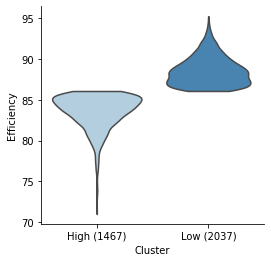

In [25]:
kmeans = KMeans(n_clusters=2, n_init=3, random_state=0)
targets["efficiency_cluster"] = kmeans.fit_predict(np.array(dataset["efficiency"]).reshape(-1, 1))
fig, ax = plt.subplots(figsize=(4,4))
n_high = len(targets[targets["efficiency_cluster"] == 0])
n_low = len(targets[targets["efficiency_cluster"] == 1])
sns.violinplot(x="efficiency_cluster",y="efficiency",palette="Blues",inner=None,cut=0,data=targets,ax=ax)
ax.set_xticklabels([f"High ({n_high})",f"Low ({n_low})"])
for loc in ["right","top"]:
    ax.spines[loc].set_visible(False)
ax.set_xlabel(ax.xaxis.get_label().get_text().split("_")[-1].title())
ax.set_ylabel(ax.yaxis.get_label().get_text().replace("_"," ").title())
plt.show()
plt.close()

We successfully split the efficiency values into an upper and lower score profile. The cell below adds the efficiency cluster to the data under the column `efficiency_low` where 0 indicates False and 1 is True. 

In [26]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
    dataset["efficiency_low"] = kmeans.fit_predict(np.array(dataset["efficiency"]).reshape(-1, 1))

##### Target: TST from Fitbit
It would be interesting to see if we can capture irregularly high or low sleep times by clustering.

2 Clusters:
	Cluster 0
		Min:	2.55
		Max:	6.7
		n:	1534
	Cluster 1
		Min:	6.716666666666668
		Max:	14.783333333333333
		n:	1970
3 Clusters:
	Cluster 0
		Min:	5.783333333333332
		Max:	7.5
		n:	1854
	Cluster 2
		Min:	2.55
		Max:	5.7666666666666675
		n:	639
	Cluster 1
		Min:	7.5166666666666675
		Max:	14.783333333333333
		n:	1011


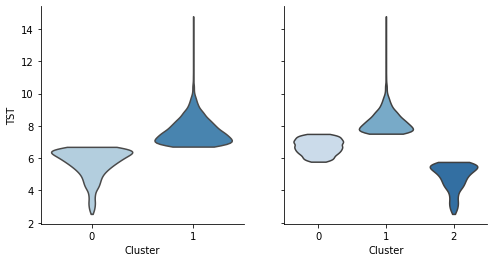

In [27]:
clusters = [2,3]
fig, axes = plt.subplots(1,len(clusters),figsize=(4*len(clusters),4),sharey=True)
for cluster, ax in zip(clusters, axes.flat):
    kmeans = KMeans(n_clusters=cluster, n_init=3, random_state=0)
    targets["tst_cluster"] = kmeans.fit_predict(np.array(dataset["tst_fb"]).reshape(-1, 1))
    sns.violinplot(x="tst_cluster",y="tst_fb",palette="Blues",inner=None,cut=0,data=targets,ax=ax)
    for loc in ["right","top"]:
        ax.spines[loc].set_visible(False)
    ax.set_xlabel(ax.xaxis.get_label().get_text().split("_")[-1].title())
    ax.set_ylabel("")
    print(f"{cluster} Clusters:")
    for tst_cluster in targets["tst_cluster"].unique():
        temp = targets[targets["tst_cluster"] == tst_cluster]
        print(f"\tCluster {tst_cluster}\n\t\tMin:\t{min(temp['tst_fb'])}\n\t\tMax:\t{max(temp['tst_fb'])}\n\t\tn:\t{len(temp)}")
    
axes[0].set_ylabel("TST")
    
plt.show()
plt.close()

The clustering seemed to work best when using 3 clusters. These clusters are **not** added to the feature sets but can be used for future analysis.

<a id="feature_data"></a>

## Feature Data
We can look at a few of the feature sets and clean up the data.

### Features: Home Environment
Features from the REDCap survey - I plan to use these rather for clustering the datasets rather than running other types of analysis.

### Features: IEQ
The IEQ feature set has a considerable amount of missing values due to reading/connection issues with many of the sensors.

#### Dropping "Duplicate" Columns
There might be some columns that are providing duplicate information i.e. they have a strong correlation with each other. In the IEQ feature set, there are potentially two situations where we might have unecessary columns:
1. **Particulate Matter**: The SPS30 measures PM by size and by concentration (number and mass), but there are going to be strong correlations between the sizes as well as the concentration types.
2. **Summarizing Statistics**: In an attempt to provide the most overarching explanation of the data, all types of summarizing stats (mean, median, std) were provided, but perhaps there is considerable overlap between the statistics. 

Correlation matrixes can help us see the relationship of these features to one another which the following function generates.

In [28]:
def plot_correlation_matrix(df,annotate=True):
    """
    Plots correlation matrix between all variables in the df
    
    Inputs:
    - df: dataframe with columns named for the varaiables
    
    """
    corr = df.corr()
    corr = round(corr,2)
    #mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr,
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,linecolor="black",annot=annotate,ax=ax)

    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right')

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=-45,ha='left')
        
    plt.show()
    plt.close()

##### Particulate Matter
Questions to answer:
- Do we need to include all size ranges?
- Do we need to include mass and number concentrations?

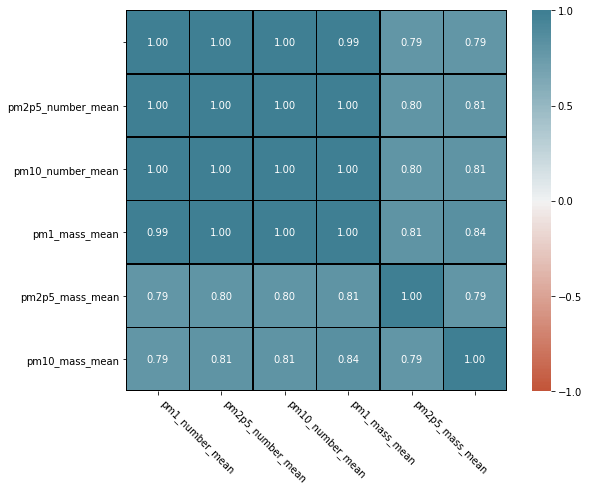

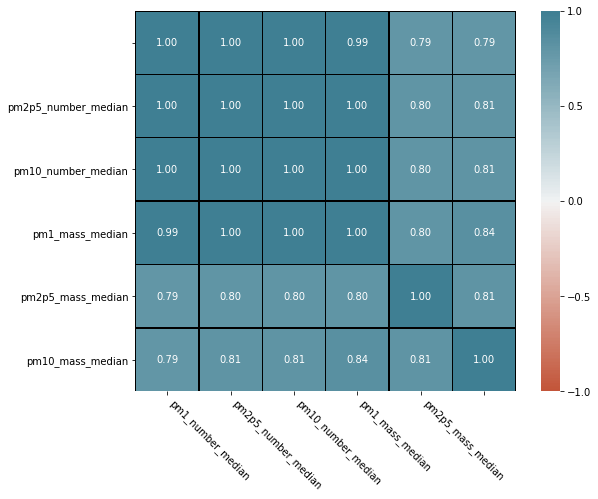

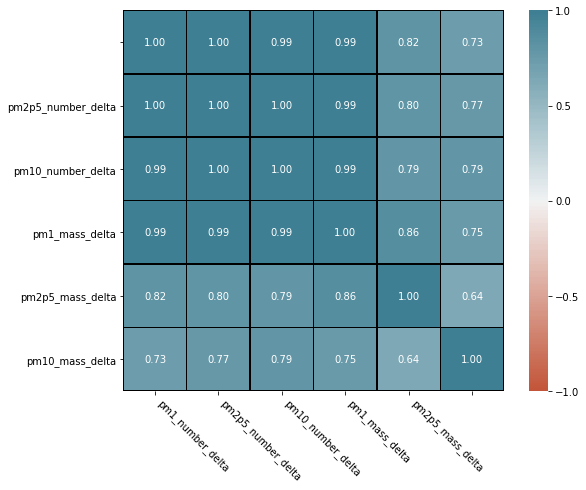

In [29]:
# PM Size Ranges
for metric in ["mean","median","delta"]:
    pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if column.startswith("pm") and column.endswith(metric)]])

<div class="alert alert-block alert-success">
    
PM2.5 number and mass concentrations can be used as a decent enough proxy for PM1 and PM10 number and mass concentrations as all correlations are 0.95 and above.
    
</div>

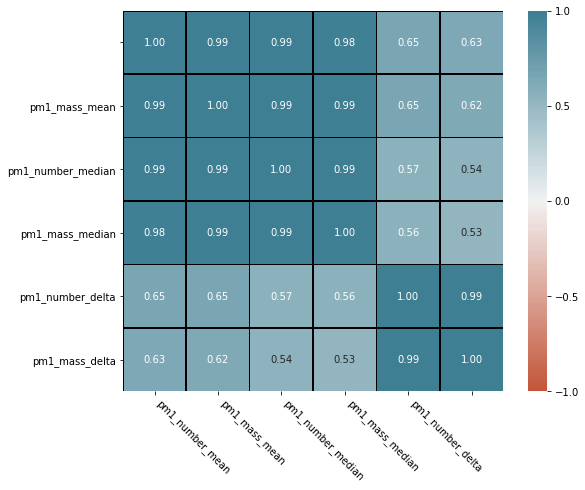

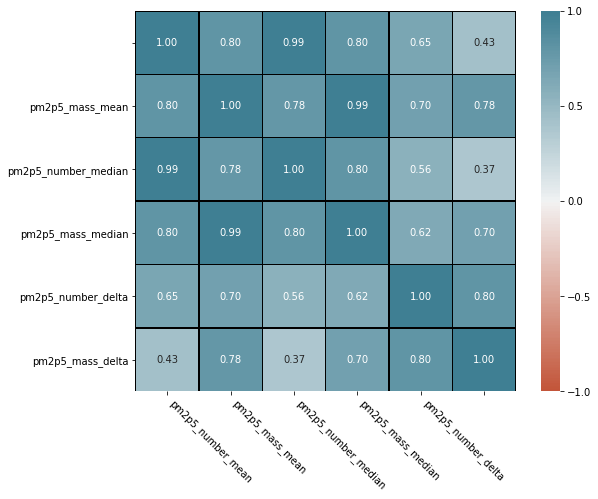

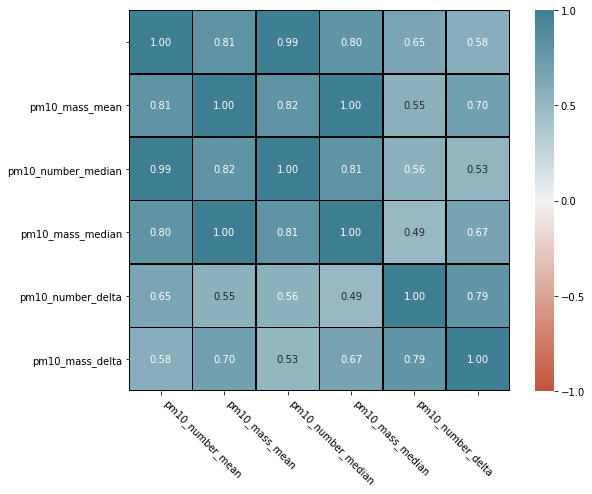

In [30]:
# PM mass and number
for size in ["1_","2p5","10"]:
    pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if column.startswith("pm"+size)]])

<div class="alert alert-block alert-danger">
    
Mass and Number concentrations should be kept separate since their relationships are not as strong.
    
</div>

##### Summarizing Statistics
One real question:
- Are there significant differences between mean and median?

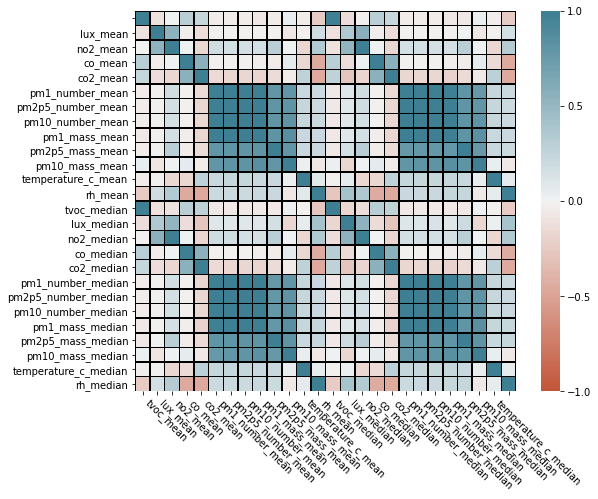

In [32]:
# PM only
pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if (column.endswith("median") or column.endswith("mean"))]],annotate=False)

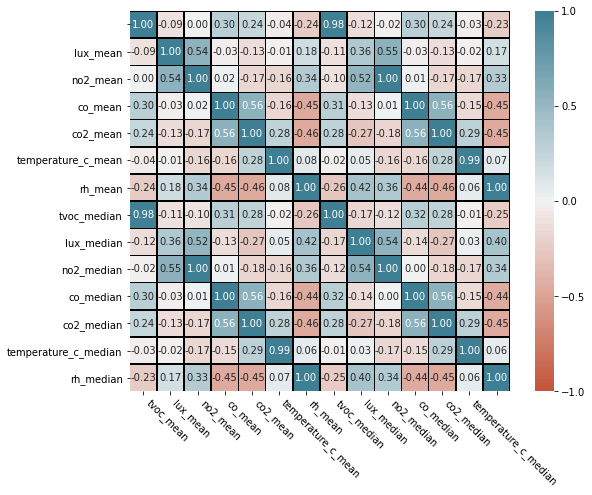

In [33]:
# Not PM
pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if not column.startswith("pm") and (column.endswith("median") or column.endswith("mean"))]],annotate=True)

<div class="alert alert-block alert-success">
    
We will remove the mean concentration values and instead consider the median values only.
    
</div>

Based on the above analysis we will drop:
1. columns that begin with `pm1` or `pm10` (really just the former since it captures the latter)
2. columns that end with `mean`

In [34]:
features_ieq.drop([column for column in features_ieq.columns if column.startswith("pm1") or column.endswith("mean")],axis="columns",errors="ignore",inplace=True)
features_ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,start_date,end_date,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem,tst_fb,waso,sol_fb,wol_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25.0,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,1.848583,23.337500,33.0,91.90,0.136,NaN,0.731650,304.035761,1.960803,2.504855,1.000,0.950,2020-08-10,2020-08-10,2,26,2,25,83.932347,28,0.217791,6.616667,60.5,0.5,15.0,10.327456,71.788413,17.884131,19.143577,82.115869,0.217791,6.624680e+07,1
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25.0,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,1.655522,25.000000,34.0,160.45,0.204,NaN,5.565250,202.651343,6.086460,2.686407,1.650,2.000,2020-08-11,2020-08-11,4,40,5,35,84.103512,44,0.256906,7.583333,85.0,1.0,0.0,13.626374,65.934066,20.439560,18.901099,79.560440,0.256906,6.684325e+07,1
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25.0,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,2.024990,24.000000,33.0,108.60,0.204,NaN,0.512533,146.009840,5.472740,2.834850,0.000,1.500,2020-08-12,2020-08-12,3,34,7,35,86.257928,37,0.189504,6.800000,59.0,0.0,6.0,12.745098,71.323529,15.931373,15.931373,84.068627,0.189504,7.471143e+07,1
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25.0,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,1.812659,25.000000,33.0,81.80,2.040,NaN,5.108383,233.372161,3.742991,2.422116,1.175,1.250,2020-08-14,2020-08-14,4,38,6,38,85.140562,42,0.218391,7.066667,61.5,1.0,11.5,11.556604,70.518868,17.924528,17.452830,82.075472,0.218391,7.054627e+07,1
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25.0,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,2.457356,23.333333,34.0,149.30,0.136,NaN,0.684917,125.544723,43.415611,11.633674,1.000,2.575,2020-08-15,2020-08-15,2,18,4,16,83.093525,20,0.320000,3.850000,38.5,8.5,0.0,15.584416,60.173160,24.242424,20.346320,75.757576,0.320000,6.338302e+07,1


#### Missing Data
The IEQ feature set has _a lot_ of missing data (relative to its size) becuase of sensor issues or the sensor simply not being installed on the beacon (looking at you NO$_2$).

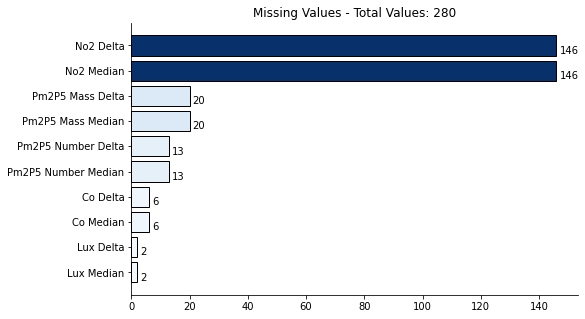

In [35]:
pp.plot_missing_data(features_ieq)

##### NO$_2$
The missing NO$_2$ values are from those beacons without the sensors, but the PM and Lux missing values deserve a little exploration.

##### PM
We need to check to see if the missing PM data is from one participant or more.

In [36]:
missing_pm = features_ieq[features_ieq["pm2p5_mass_median"].isnull()]
missing_pm.describe()

,beacon,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem,tst_fb,waso,sol_fb,wol_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
count,20.000000,20.000000,20.000000,20.000000,20.000000,7.000000,20.000000,20.000000,7.000000,0.0,20.000000,20.000000,20.000000,20.000000,7.000000,20.000000,20.000000,7.0,0.0,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,30.350000,41.150000,43.300000,192.016389,10.429256,1.323565,1.946785,842.671217,5.518752,NaN,27.712083,46.591667,111.756111,23.761348,0.173579,0.738386,92.100918,0.0,NaN,0.822917,4.717500,3.300000,23.85000,7.050000,25.600000,85.689988,27.150000,0.234356,5.837500,46.025000,6.250000,3.525000,20.730449,61.035940,18.233611,16.939747,81.766389,0.234356,7.367530e+07,0.550000
std,19.085059,4.404244,8.808489,50.583043,10.050422,0.035801,1.077444,506.186093,0.000000,NaN,0.770848,6.234555,48.095842,15.995718,0.052034,0.252678,64.586820,0.0,NaN,0.531101,3.221961,1.218282,8.20959,3.284333,9.805476,3.967185,8.731522,0.125823,1.652075,18.657914,7.062689,5.706587,5.214429,6.475363,7.848430,5.468926,7.848430,0.125823,1.491226e+07,0.510418
min,5.000000,38.000000,37.000000,50.283333,0.000000,1.288470,1.041625,426.243622,5.518752,NaN,27.000000,37.000000,33.861111,0.000000,0.085262,0.320700,11.403342,0.0,NaN,0.000000,0.250000,2.000000,11.00000,1.000000,11.000000,76.605505,14.000000,0.031414,2.550000,10.500000,0.000000,0.000000,10.622711,49.176955,3.045685,6.250000,63.003663,0.031414,4.432351e+07,0.000000
25%,5.000000,38.000000,37.000000,173.336111,0.000000,1.292740,1.201425,484.434376,5.518752,NaN,27.000000,39.962500,73.400000,8.878958,0.146911,0.560312,43.228694,0.0,NaN,0.470833,1.958333,2.750000,18.75000,5.000000,18.000000,83.343337,21.500000,0.155379,4.650000,34.875000,0.500000,0.000000,17.403005,57.678054,13.427241,13.333169,77.465714,0.155379,6.422580e+07,0.000000
50%,44.000000,38.000000,37.000000,186.079167,9.142883,1.332177,1.301108,503.414763,5.518752,NaN,27.450000,49.500000,112.113889,28.323360,0.181576,0.743228,79.942490,0.0,NaN,1.000000,4.325000,3.000000,22.50000,6.500000,24.500000,84.729376,25.500000,0.223931,6.575000,46.750000,5.000000,0.000000,20.837454,59.833358,18.275912,18.026700,81.724088,0.223931,6.907653e+07,1.000000
75%,44.000000,47.000000,55.000000,230.675000,18.034365,1.335299,2.709283,1358.180160,5.518752,NaN,28.500000,52.000000,138.750000,34.484160,0.207771,0.926004,128.761222,0.0,NaN,1.000000,7.583333,4.000000,28.50000,9.250000,32.000000,88.235520,32.000000,0.290895,6.991667,54.500000,9.500000,4.500000,24.856968,65.092317,22.534286,19.985628,86.572759,0.290895,8.254723e+07,1.000000
max,44.000000,47.000000,55.000000,264.700000,28.888440,1.388229,4.205400,1774.757744,5.518752,NaN,29.000000,55.083333,218.550000,46.079520,0.238848,1.246750,233.205285,0.0,NaN,2.000000,9.833333,6.000000,44.00000,13.000000,47.000000,94.117647,48.000000,0.587209,8.100000,78.000000,26.000000,19.000000,29.341317,77.339901,36.996337,30.538922,96.954315,0.587209,1.096504e+08,1.000000


Looks like the missing PM data comes from only one participant but the remaining data looks fine (except for the NO2 data, of course). 

We should check to see if these 13 nights are an isolated incident or the PM sensor on the device was never working.

In [37]:
print("Number of nights of data:", len(features_ieq[features_ieq["beacon"] == 44]))
print("Number of nights with PM data:", len(features_ieq[(features_ieq["beacon"] == 44) & (features_ieq["pm2p5_mass_median"] > 0)]))

Number of nights of data: 24
Number of nights with PM data: 11


##### Light
The light values are not as important so we can simply fill the light levels in with an assumed value. Since we are looking at IEQ measurements during the evening, the light level should be approximately 0.

In [38]:
for column in features_ieq.columns:
    if column.startswith("lux"):
        features_ieq[column] = features_ieq[column].fillna(value=0)

Now checking again, we can see we no longer have missing light values.

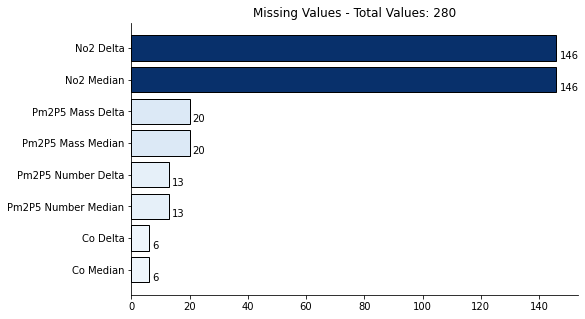

In [39]:
pp.plot_missing_data(features_ieq)

### Self-Report Mood
Now we look at the self-report mood scores

#### Correlated Features
There are most likely correlations with the mood scores that participants report, but these might not be strong enough to justify removing/grouping them in the dataset.

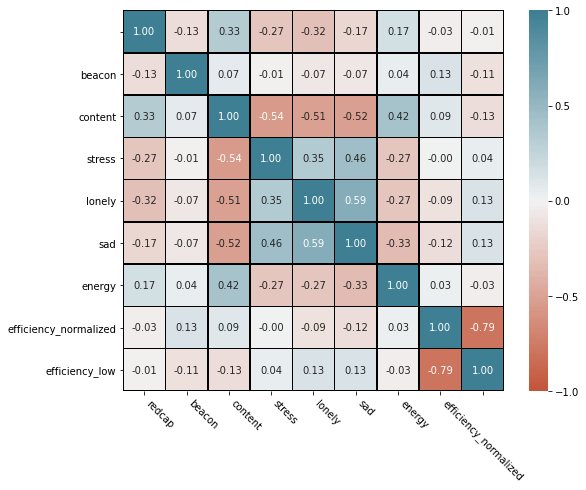

In [40]:
pp.plot_correlation_matrix(features_mood[[column for column in features_mood.columns if column not in targets.columns]],annotate=True)

<div class="alert alert-block alert-info">
    
The most pronounced relationship is between `content` scores and and those of `stress`, `sad`, and `lonely`. Perhaps later analysis can provide a way to combine these "negative" emotional states since there is also an equally strong relationship between `stress` and `sad`.
    
</div>

#### Missing Data
There are some questions that participants opted not to answer for whatever reason. If there are only a few we can justify dropping the row.

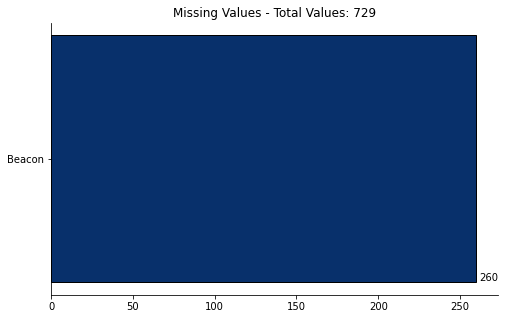

In [41]:
pp.plot_missing_data(features_mood)

A large amount of `beacon` listings are missing from the dataset but that is simply because not all participants received a beacon. The remaining rows are dropped to return a complete dataset.

In [42]:
features_mood.dropna(subset=["content","stress","lonely","sad","energy"],inplace=True)

### Self-Report Sleep

#### Correlated Features

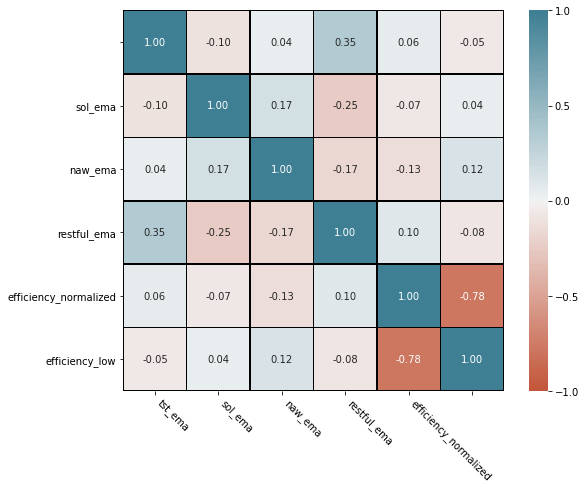

In [43]:
pp.plot_correlation_matrix(features_srsm[[column for column in features_srsm.columns if column not in targets.columns and column not in ["beacon","redcap"]]],annotate=True)

<div class="alert alert-block alert-info">
    
There do not seem to be any strongly correlated features within the self-repoty sleep metrics which is good in terms of modeling but bad because there should be some level of correlation between `restful` and other sleep metrics like `naw`.
    
</div>

#### Missing Data
Similar to the self-report mood scores, there might be some participants that opted not to answer one of the questions in the sleep survey for whatever reason.

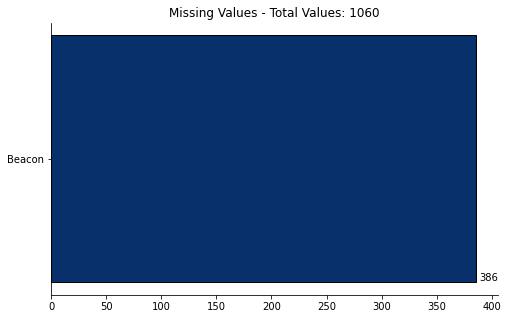

In [44]:
pp.plot_missing_data(features_srsm)

##### Checking for -1
The initial encoding of missing values created -1 in place of NaN. We check to make sure that has been rectified.

In [45]:
for column in ["tst_ema","naw_ema","sol_ema","restful_ema"]:
    li = sorted(features_srsm[column].unique())
    if -1 in li:
        print("-1 found in column", column)

<div class="alert alert-block alert-success">
    
There are no missing values from the self-report sleep metrics (other than the beacons of course since, again, not all participants got beacons.
    
</div>

### Activity
Our largest and final feature set.

#### Correlated Features
There should be a fair amount of correlated features considering some are derivatives of others.

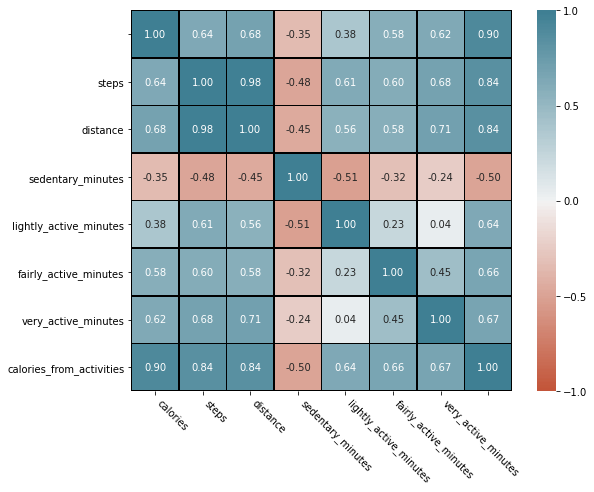

In [46]:
pp.plot_correlation_matrix(features_activity[[column for column in features_activity.columns if column not in targets.columns and column not in ["beacon","redcap"] and not column.startswith("eff")]],annotate=True)

<div class="alert alert-block alert-success">
    
There are a fair amount of highly-correlated variables, but the only one I feel comfortable removing is the `distance` feature in favor of only considering the `steps` feature since they have a 0.98 correlation.
    
</div>

In [47]:
features_activity.drop(["distance"],axis="columns",inplace=True)

#### Missing Data
Barring any odd occurence with some component of the Fitbit device, there should be no missing data.

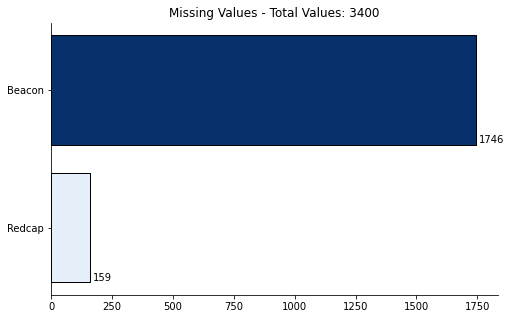

In [48]:
pp.plot_missing_data(features_activity)

<div class="alert alert-block alert-success">
    
Again the only missing values are from the `beacon` and `redcap` ID columns which make sense. The 159 missing values are from the ULG participants.
    
</div>

### Dropping Unecessary Columns
There columns that can be removed because they do not provide any insight:
- ID Columns: `beacon`, `beiwe`, `fitbit`
- Timestamps: `start_time`, `end_time`, `date`, etc.

In [49]:
id_columns = ["beacon","beiwe","fitbit"]
dt_columns = ["start_time","end_time","date","start_date","end_date","timestamp"]
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    dataset = dataset.drop(id_columns+dt_columns,axis="columns",errors="ignore",inplace=True)

<div class="alert alert-block alert-info">
    
We **do** keep the `redcap` ID column though because later analysis has us looking on an individual basis so we need a way to parse out the participants. 
    
</div>

<a id='feature_engineering'></a>

# Feature Engineering
We follow along some basic guidelines that are outlined in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course on [Kaggle](https://www.kaggle.com). The general outline is given as follows:

- [Mutual Information](#mutual_information)
- [Clustering](#clustering)
- [Principal Component Analysis](#pca)

Much of this code has been refractured into the `build_features` source code and we import that module below so that we can simplify the code presented in this notebook.

In [52]:
from src.features import feature_engineering
# defining feature engineering object
fe = feature_engineering.fe()

<a id='mutual_information_aggregate'></a>

## Mutual Information - Aggregate
Using mutual information, we can get an initial insight into which features relate most closely with the sleep metric targets from Fitbit. This analysis only compares one feature to the target, but there might be more underlying relationships which we can explore further in later sections.

### Testing Applicability
The best way to see MI in action is to look at two variables that should explain one another like the _same_ variable.

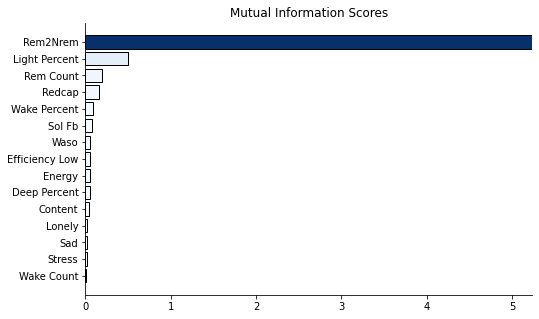

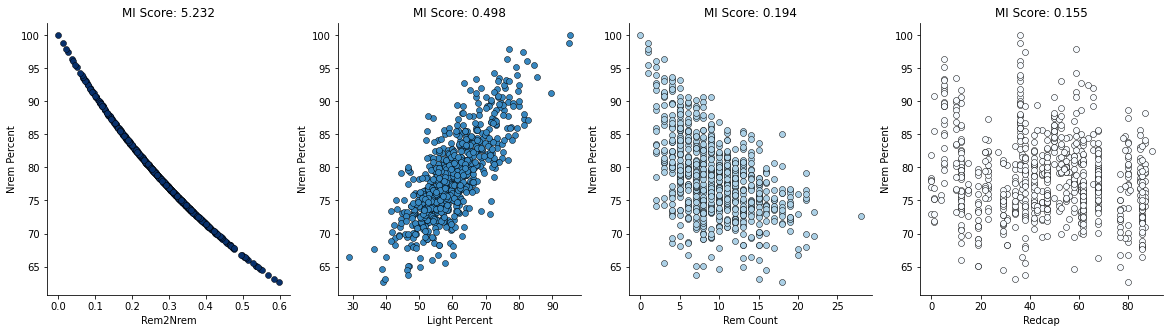

True

In [54]:
target_labels = ["nrem_percent","rem_percent","rem2nrem_percent","tst_fb","efficiency","efficiency_normalized"]
test = features_mood.copy()
fe.check_features_against_targets(test,target_labels,features_to_show=4,tolerance=0.01)

<div class="alert alert-block alert-success">
    
MI seems to produce reasonable results given strong relationships amongst variables. 
    
</div>

### Sepcific Case: NO$_2$
Since not all the Beacons had NO$_2$ sensors, we have to split our IEQ feature sets.

In [55]:
features_ieq_no2 = features_ieq.copy()[[column for column in features_ieq.columns if column in targets.columns or column in ["redcap","no2_median","no2_delta"] or column.startswith("eff")]]
features_ieq_no2.describe()

,redcap,no2_median,no2_delta,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem,tst_fb,waso,sol_fb,wol_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
count,280.000000,134.000000,134.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,2.800000e+02,280.000000
mean,43.046429,1.172192,0.134684,3.525000,27.050000,9.060714,29.246429,86.989353,30.575000,0.259138,6.674464,51.925000,4.650000,3.421429,18.572868,61.276041,20.151091,15.089562,79.848909,0.259138,7.818868e+07,0.446429
std,16.861272,0.287441,0.171226,1.383239,7.954463,4.244316,8.322358,2.933078,8.709247,0.091291,1.306610,18.941754,5.779924,5.553671,5.981680,8.842024,5.980619,3.965566,5.980619,0.091291,1.132728e+07,0.498012
min,10.000000,0.704758,0.000000,0.000000,8.000000,0.000000,7.000000,74.095238,10.000000,0.000000,2.550000,6.500000,0.000000,0.000000,0.000000,40.111421,0.000000,5.292479,63.003663,0.000000,3.828009e+07,0.000000
25%,36.000000,0.986901,0.035609,3.000000,22.000000,6.000000,24.000000,85.063455,25.000000,0.203883,6.095833,38.875000,0.000000,0.000000,15.379607,55.282042,16.935305,12.459863,75.609488,0.203883,7.026564e+07,0.000000
50%,42.000000,1.087990,0.065026,3.000000,26.000000,9.000000,29.000000,87.089057,30.000000,0.265853,6.766667,51.500000,1.000000,0.000000,18.992320,59.776959,21.001910,14.824990,78.998090,0.265853,7.793088e+07,0.000000
75%,53.000000,1.289277,0.174197,4.000000,32.000000,12.000000,35.000000,88.920616,36.000000,0.322586,7.420833,63.250000,7.500000,5.500000,22.485445,66.279546,24.390512,17.559303,83.064695,0.322586,8.540384e+07,1.000000
max,68.000000,2.032779,1.370703,8.000000,51.000000,22.000000,55.000000,94.973545,59.000000,0.587209,10.133333,136.000000,28.000000,31.000000,33.333333,95.047170,36.996337,34.961440,100.000000,0.587209,1.141058e+08,1.000000


In [56]:
features_ieq_no_no2 = features_ieq.copy()
features_ieq_no_no2.drop(["no2_median","no2_delta"],axis="columns",inplace=True)
features_ieq_no_no2.describe()

,redcap,tvoc_median,lux_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem,tst_fb,waso,sol_fb,wol_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
count,280.000000,280.000000,280.000000,274.000000,280.000000,267.000000,260.000000,280.000000,280.000000,280.000000,280.000000,274.000000,280.000000,267.000000,260.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,2.800000e+02,280.000000
mean,43.046429,256.740079,3.036132,2.703967,971.102965,8.174135,3.864662,26.929033,42.311984,197.001508,29.173795,1.143856,193.982784,10.067115,6.024319,1.189216,3.223442,3.525000,27.050000,9.060714,29.246429,86.989353,30.575000,0.259138,6.674464,51.925000,4.650000,3.421429,18.572868,61.276041,20.151091,15.089562,79.848909,0.259138,7.818868e+07,0.446429
std,16.861272,136.820373,8.620005,2.457594,520.017863,8.212035,3.115454,1.907794,5.387791,256.902551,154.735846,1.454638,156.021426,13.519934,8.959897,0.757709,2.237353,1.383239,7.954463,4.244316,8.322358,2.933078,8.709247,0.091291,1.306610,18.941754,5.779924,5.553671,5.981680,8.842024,5.980619,3.965566,5.980619,0.091291,1.132728e+07,0.498012
min,10.000000,9.500000,0.000000,0.000525,426.243622,0.469432,0.952144,22.500000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,7.000000,74.095238,10.000000,0.000000,2.550000,6.500000,0.000000,0.000000,0.000000,40.111421,0.000000,5.292479,63.003663,0.000000,3.828009e+07,0.000000
25%,36.000000,186.862500,0.000000,1.117450,730.713995,2.872435,1.856033,25.087500,38.987500,87.512500,0.000000,0.488604,96.165065,4.081318,2.723520,0.950000,2.000000,3.000000,22.000000,6.000000,24.000000,85.063455,25.000000,0.203883,6.095833,38.875000,0.000000,0.000000,15.379607,55.282042,16.935305,12.459863,75.609488,0.203883,7.026564e+07,0.000000
50%,42.000000,237.100000,0.000000,2.379833,860.684524,6.645753,3.118307,27.000000,41.479167,135.775000,2.040000,0.829467,164.117869,6.314100,4.359458,1.000000,2.708333,3.000000,26.000000,9.000000,29.000000,87.089057,30.000000,0.265853,6.766667,51.500000,1.000000,0.000000,18.992320,59.776959,21.001910,14.824990,78.998090,0.265853,7.793088e+07,0.000000
75%,53.000000,315.466667,0.529125,3.352163,1077.085822,10.267419,4.739556,28.000000,45.108333,218.100000,9.075960,1.402137,240.479626,10.493472,6.327931,1.808333,3.860417,4.000000,32.000000,12.000000,35.000000,88.920616,36.000000,0.322586,7.420833,63.250000,7.500000,5.500000,22.485445,66.279546,24.390512,17.559303,83.064695,0.322586,8.540384e+07,1.000000
max,68.000000,1330.841667,50.910240,11.352267,4956.150228,81.959036,32.106473,33.000000,61.000000,3157.950000,1697.035200,17.219500,921.162930,110.407429,92.616879,4.333333,15.725000,8.000000,51.000000,22.000000,55.000000,94.973545,59.000000,0.587209,10.133333,136.000000,28.000000,31.000000,33.333333,95.047170,36.996337,34.961440,100.000000,0.587209,1.141058e+08,1.000000


### Application Across Feature Sets
Now that we have working code, we can loop through all the feature sets and pull out the important information.

Dataset: IEQ - NO2


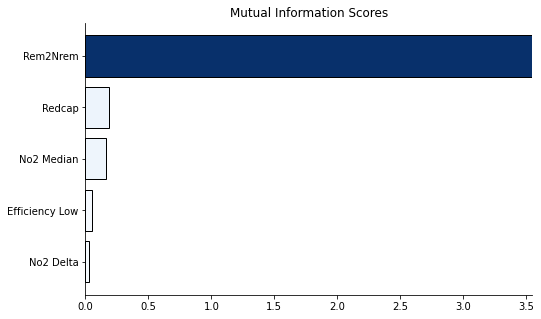

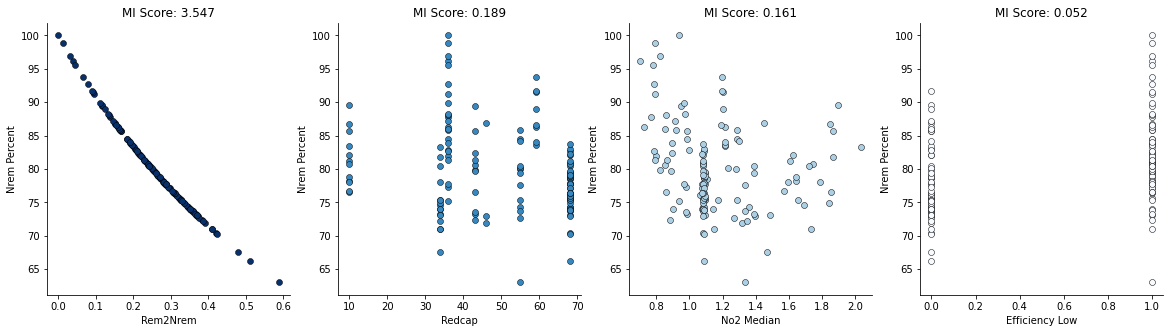

Dataset: IEQ - No NO2


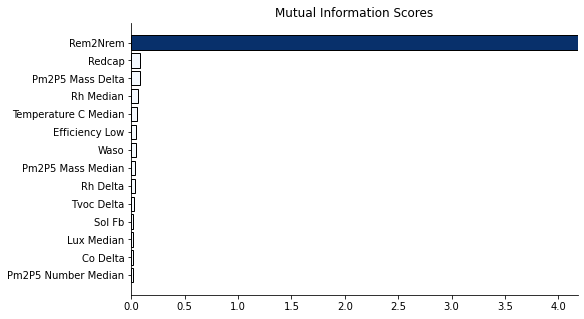

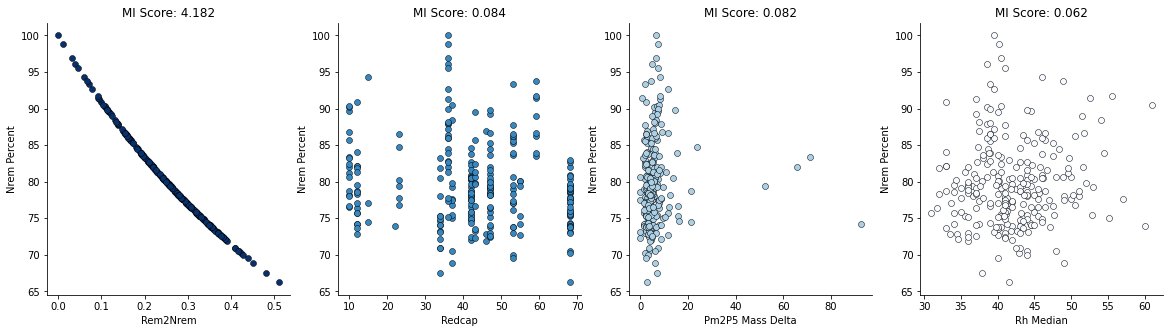

Dataset: Mood


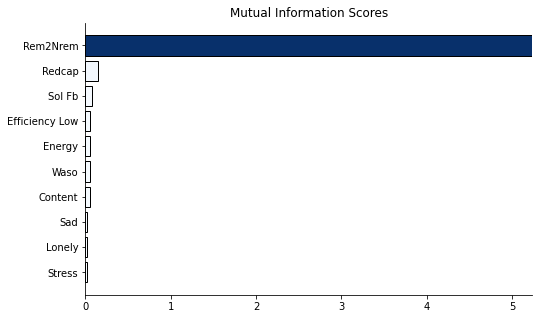

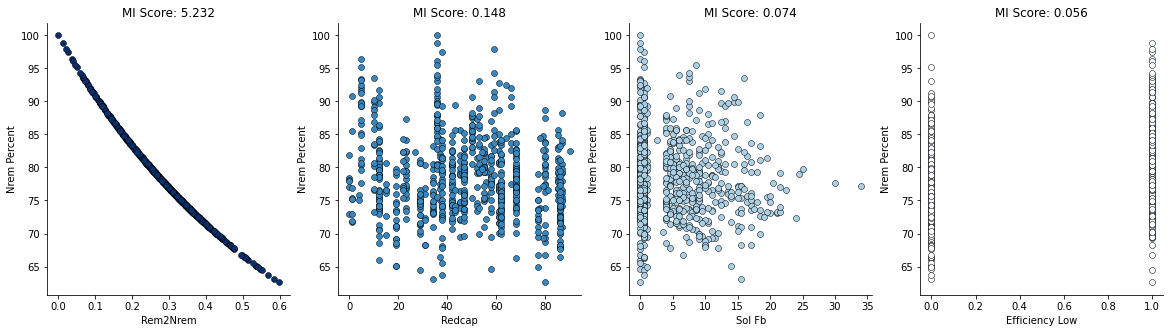

Dataset: Self-Report Sleep


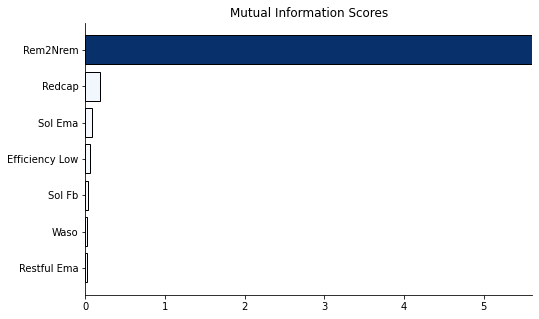

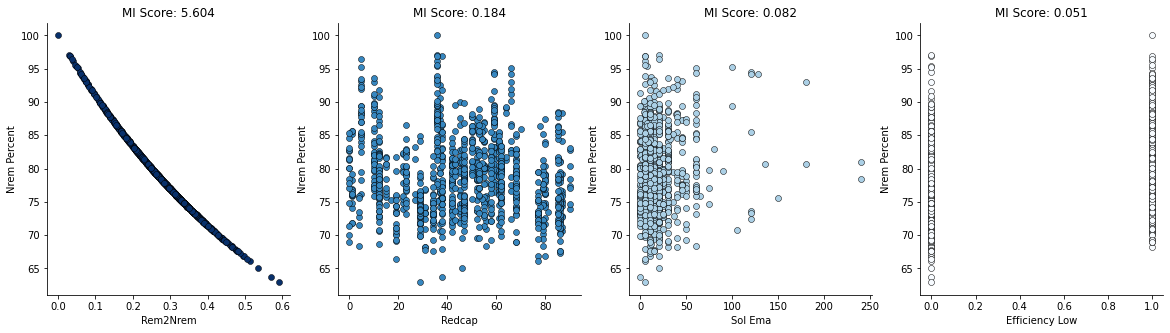

Dataset: Activity


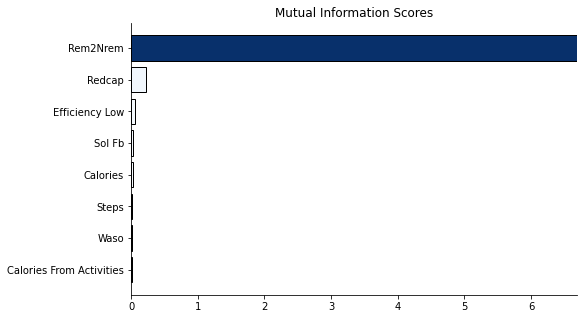

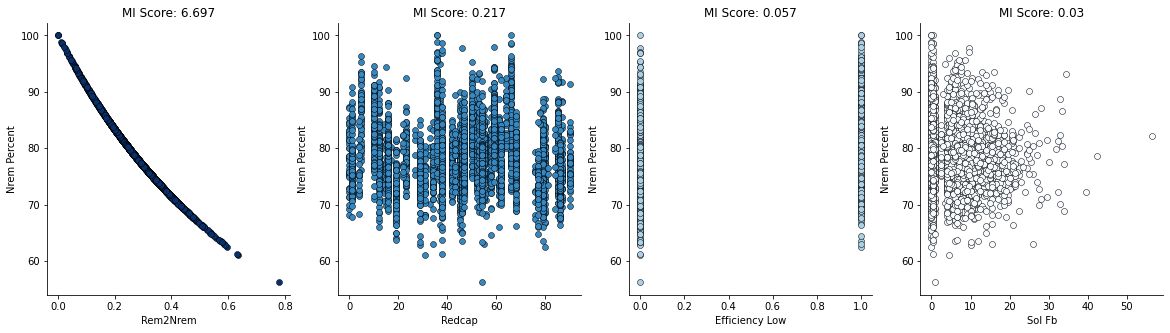

In [57]:
datasets = [features_ieq_no2, features_ieq_no_no2,features_mood, features_srsm, features_activity]
dataset_names = ["IEQ - NO2","IEQ - No NO2","Mood","Self-Report Sleep","Activity","Environment and Experiences"]
vars_to_omit = [var for var in labels.columns if var.endswith("count") or var.endswith("minutes")] + ["light_percent","deep_percent","wake_percent"]
target_labels = ["nrem_percent","rem_percent","rem2nrem_percent","tst_fb","efficiency","efficiency_normalized"]
# looping through feature sets and targets
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    _ = fe.check_features_against_targets(temp,target_labels,features_to_show=4,tolerance=0.01)

##### Results

MI Scores:
- **MI > 0.2**: `BMI`, `BMR`, `Weight` -> `Efficiency`

#### Specific Case: Efficiency
Now we can run the same mutual information analysis we ran before, but only consider the higher efficiencies in the larger cluster.

Dataset: IEQ - NO2


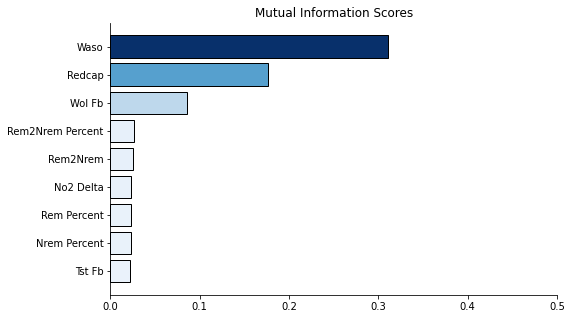

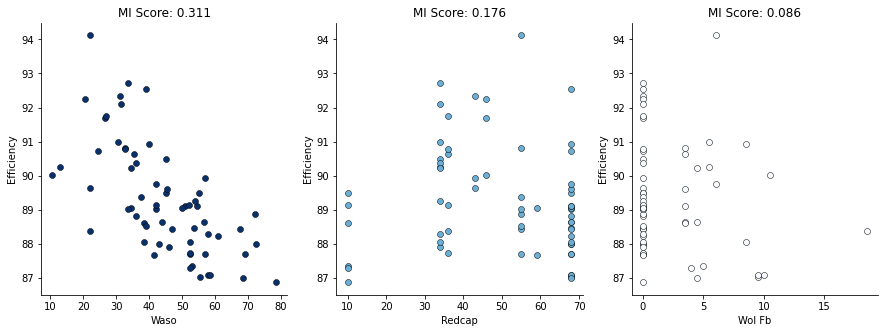

Dataset: IEQ - No NO2


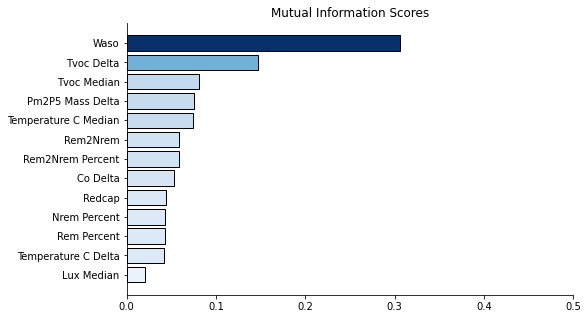

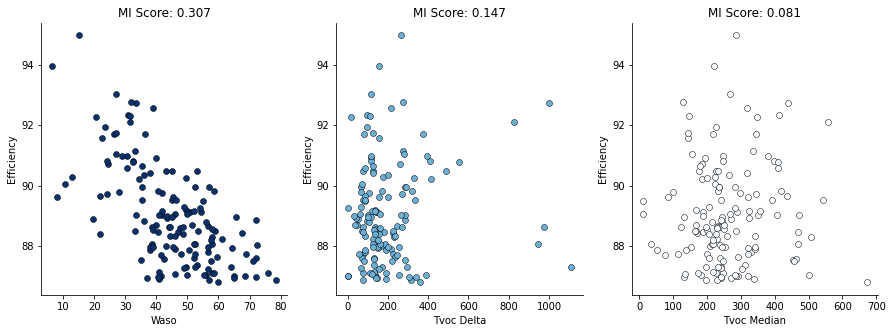

Dataset: Mood


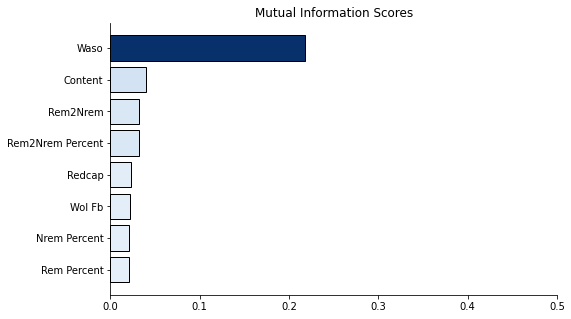

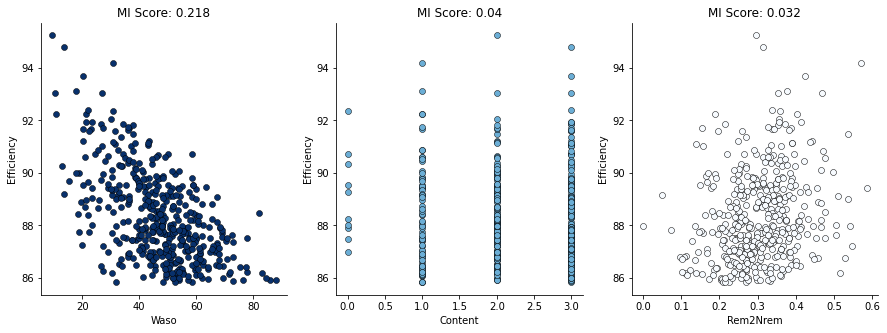

Dataset: Self-Report Sleep


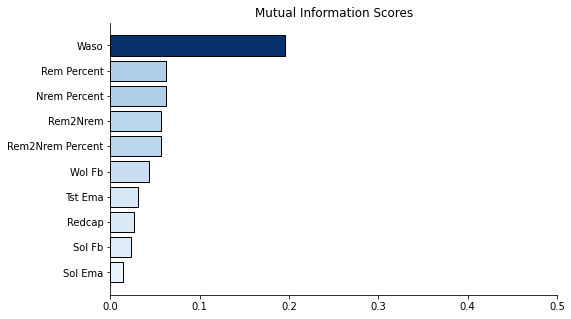

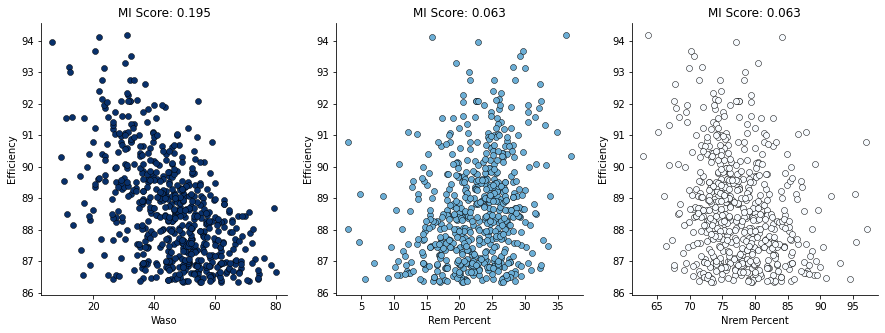

Dataset: Activity


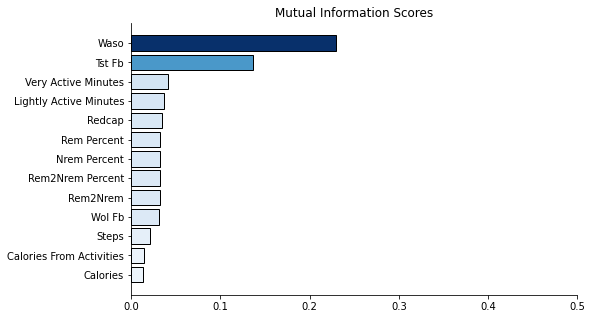

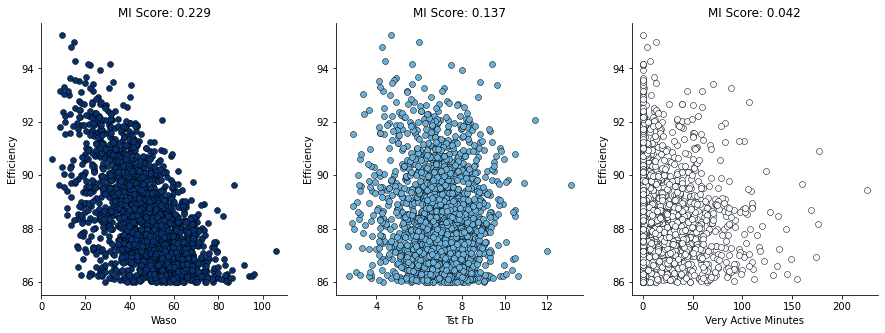

In [58]:
target_labels = ["efficiency"]
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(vars_to_omit+["efficiency_normalized"],axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    temp = temp[temp["efficiency_low"] == 0]
    
    fe.check_features_against_targets(temp,target_labels)

<a id="clustering"></a>

<a id="mutual_information_individual"></a>

## Mutual Information - Individual
Now we perform similar analysis as above but on an individual level to see if certain participants have a greater response to various features.

Dataset: IEQ - NO2


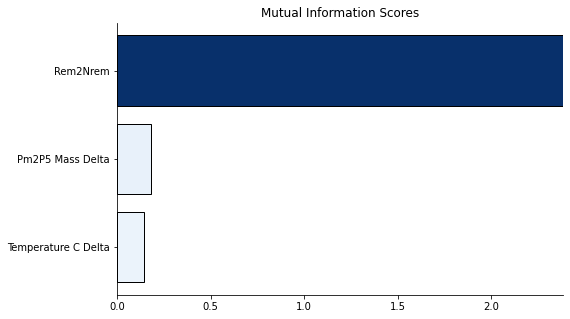

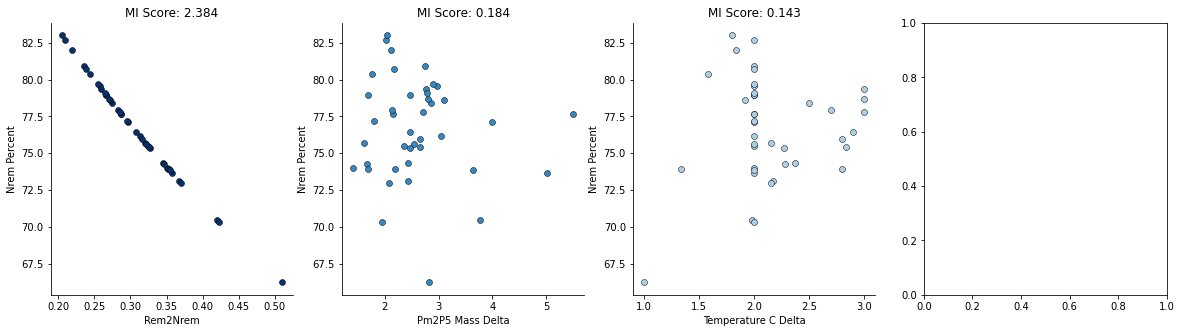

Participant: 68 - Number of Datapoints: 41


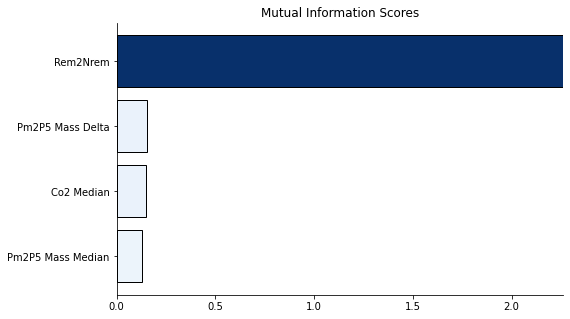

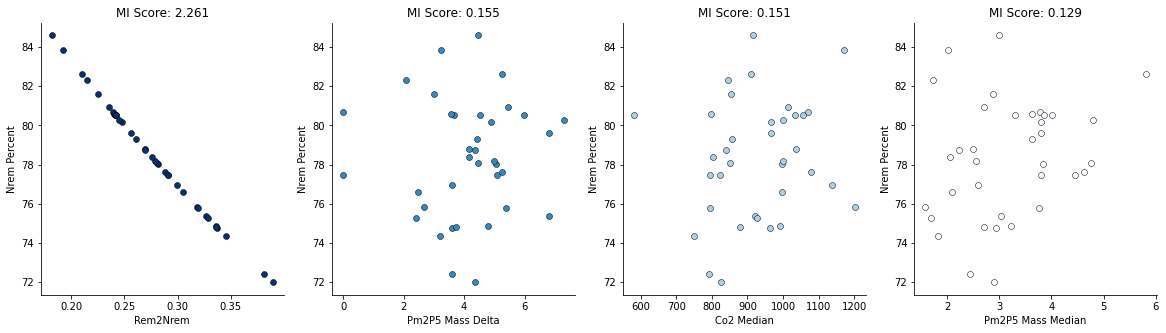

Participant: 42 - Number of Datapoints: 36


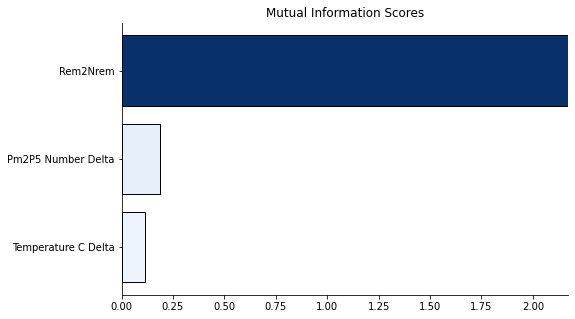

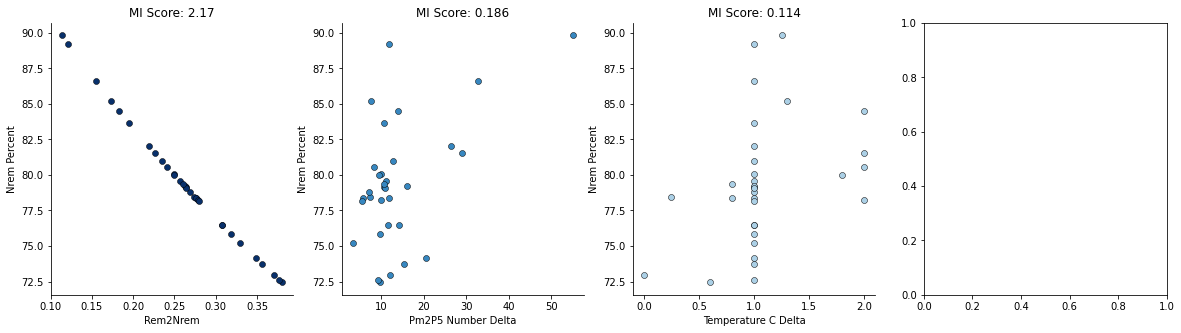

Participant: 47 - Number of Datapoints: 32
Dataset: IEQ - No NO2


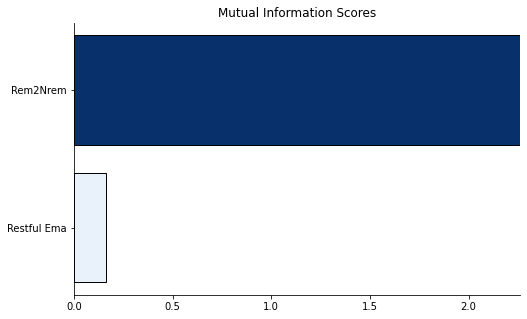

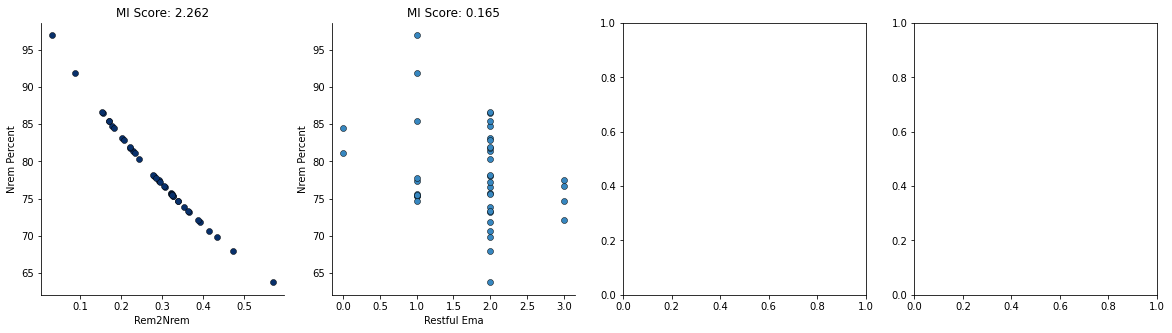

Participant: 38 - Number of Datapoints: 40


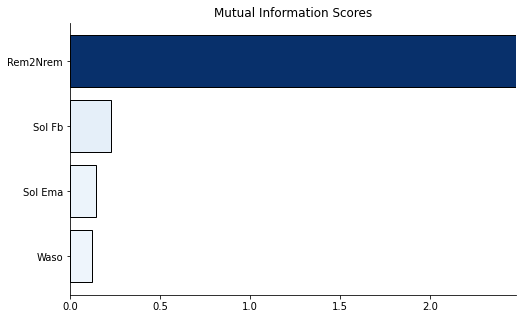

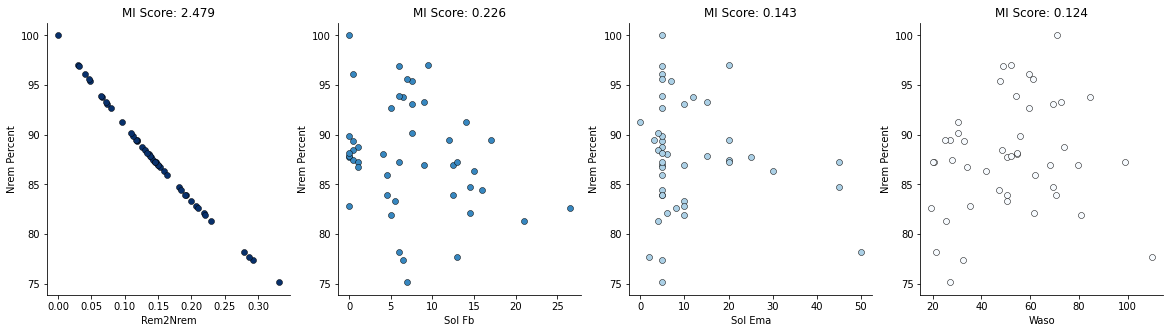

Participant: 36 - Number of Datapoints: 46


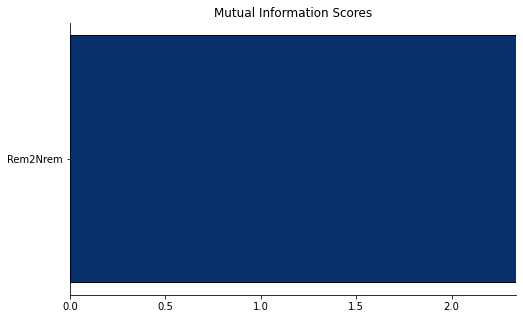

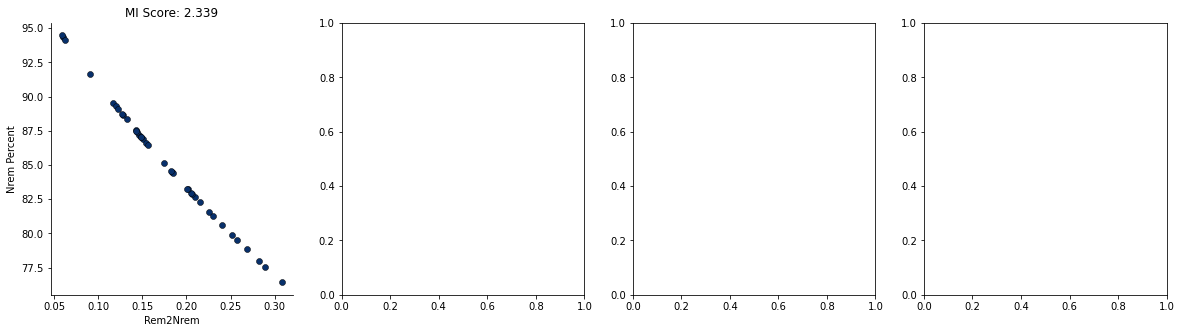

Participant: 59 - Number of Datapoints: 38


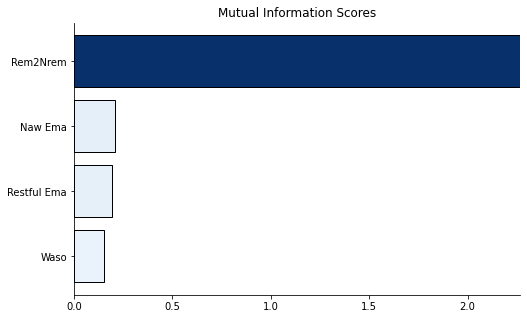

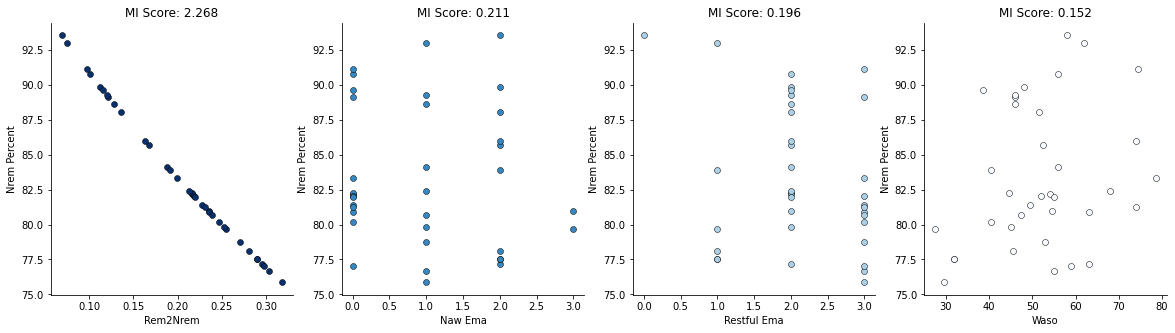

Participant: 10 - Number of Datapoints: 36


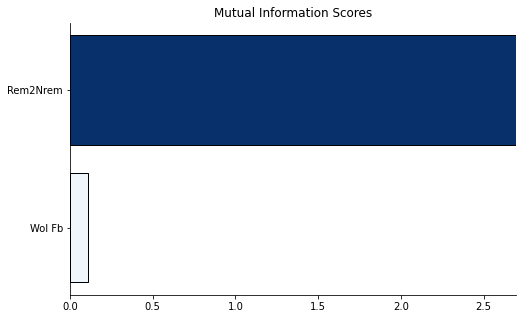

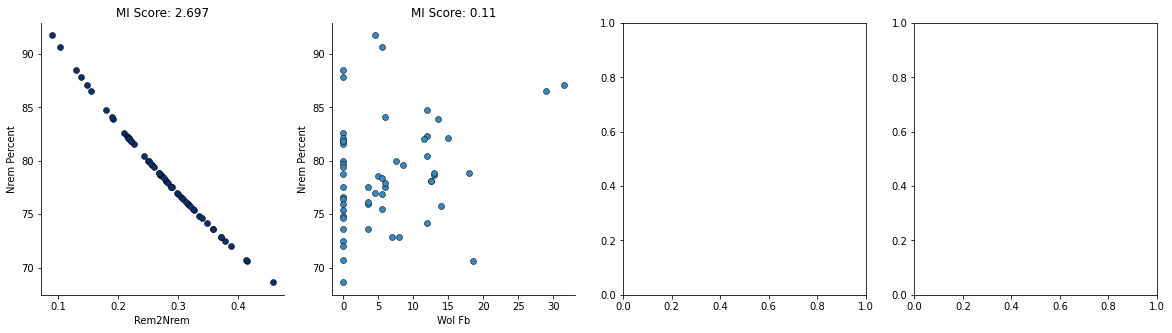

Participant: 12 - Number of Datapoints: 57


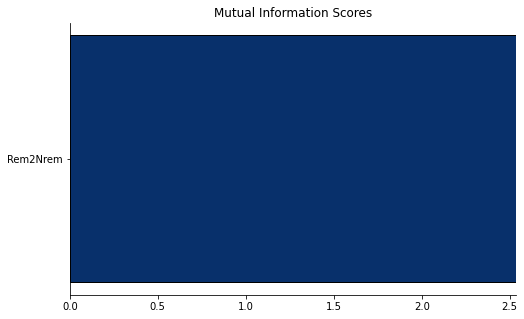

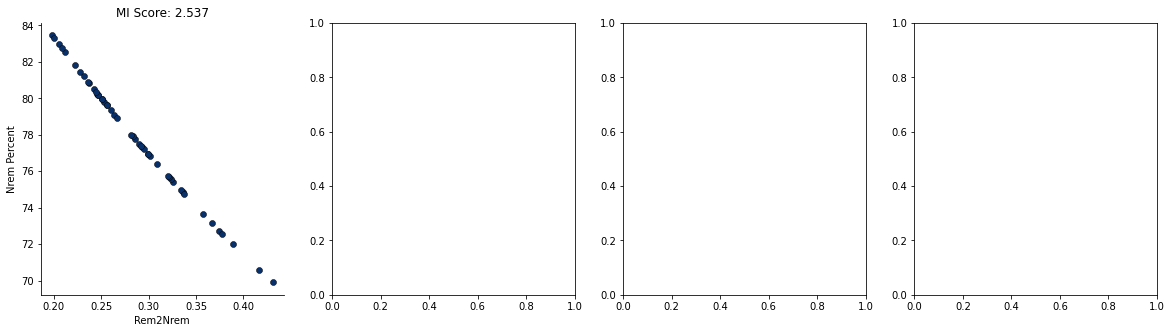

Participant: 62 - Number of Datapoints: 48


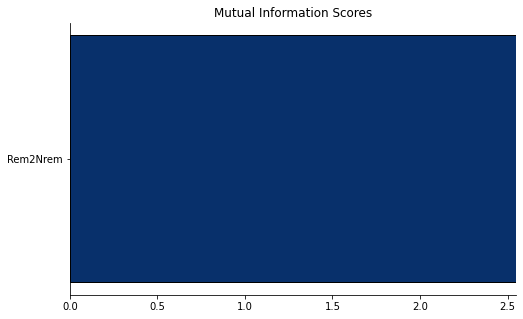

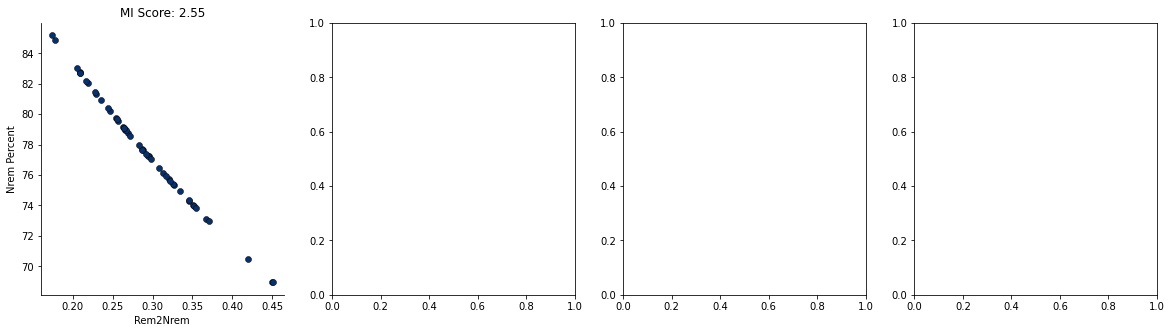

Participant: 68 - Number of Datapoints: 49


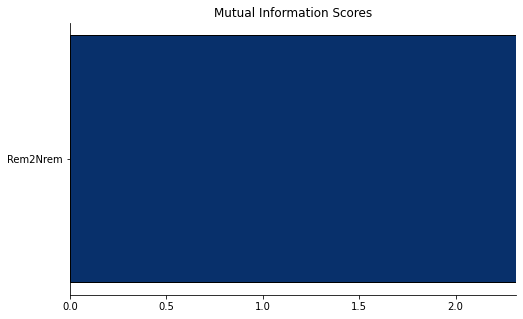

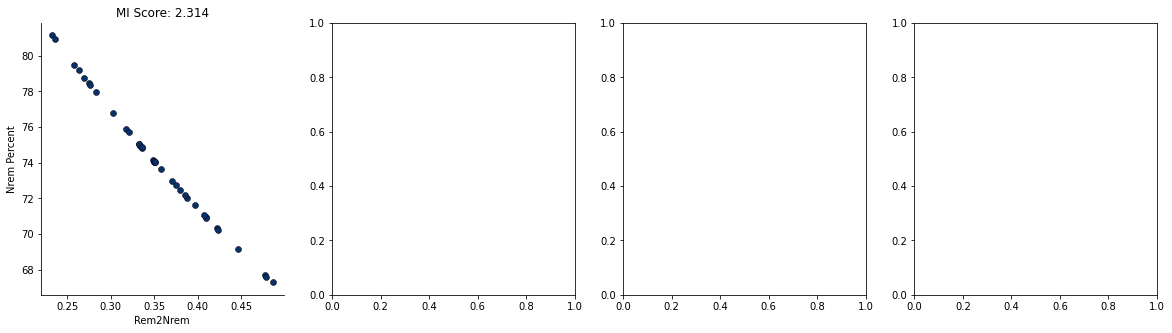

Participant: 86 - Number of Datapoints: 37


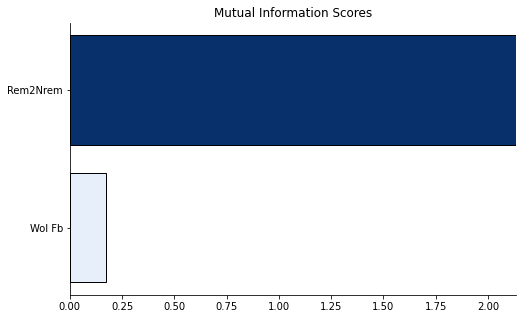

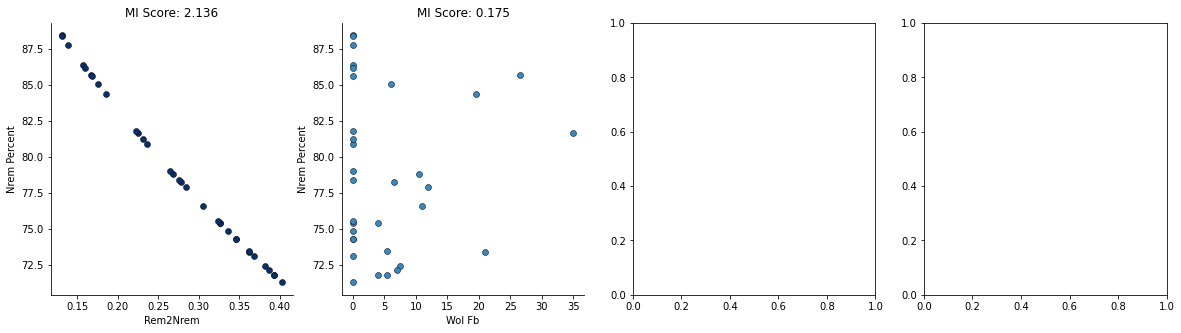

Participant: 85 - Number of Datapoints: 33


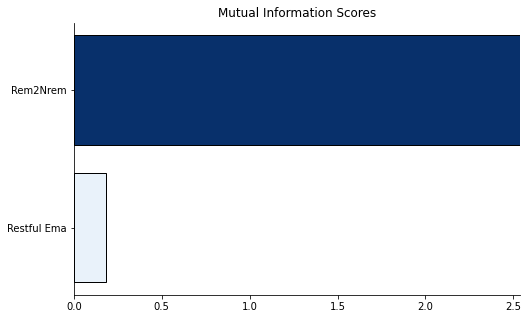

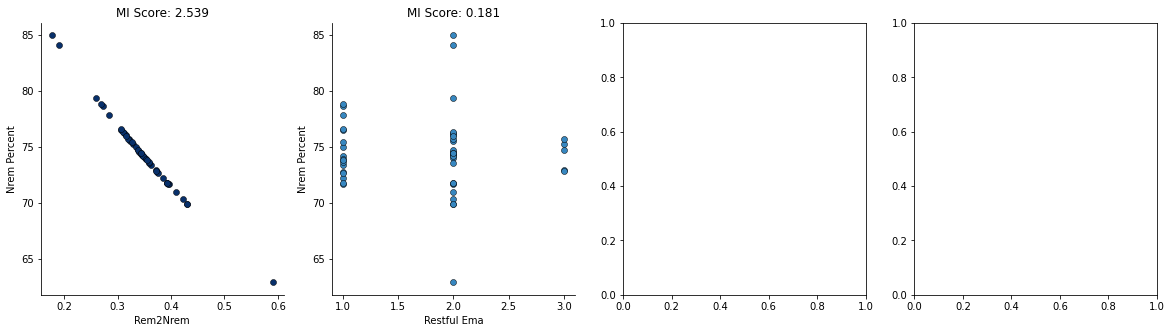

Participant: 29 - Number of Datapoints: 48


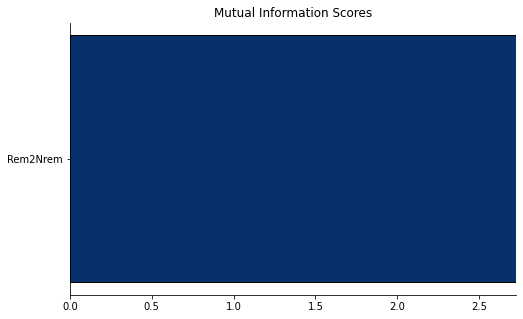

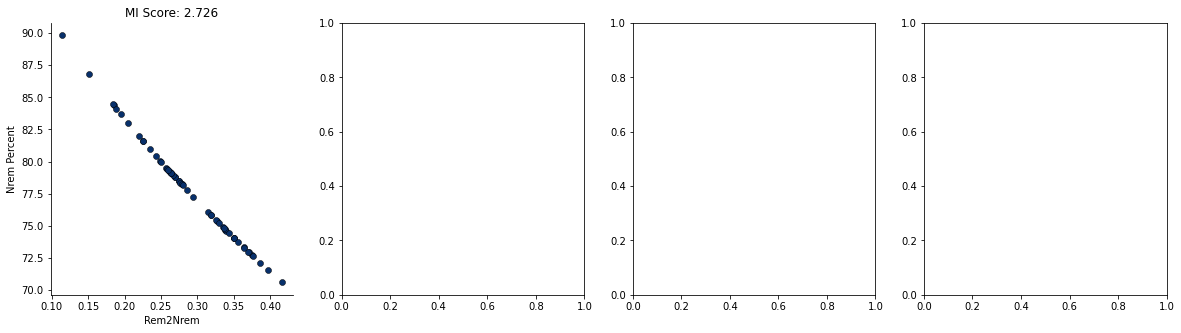

Participant: 47 - Number of Datapoints: 58


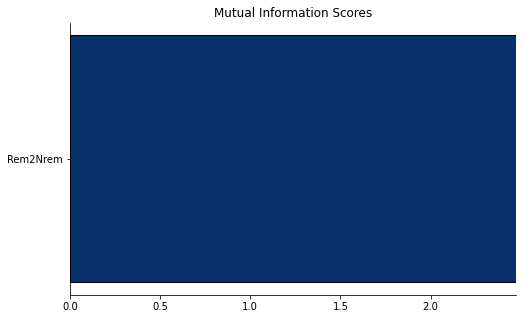

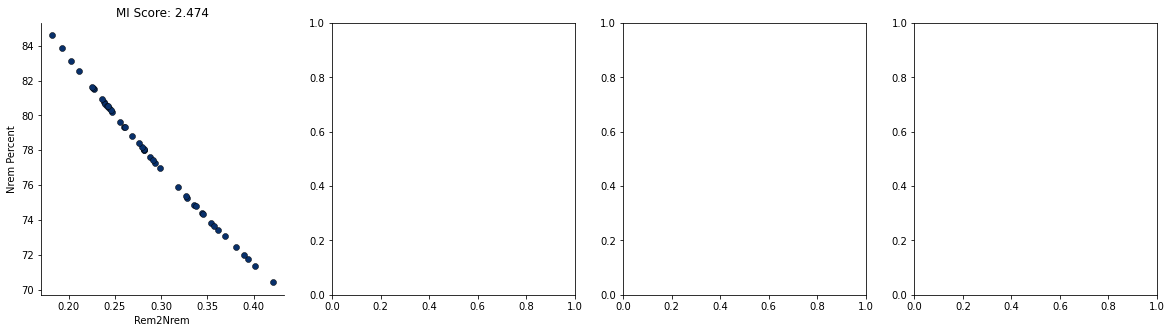

Participant: 42 - Number of Datapoints: 44


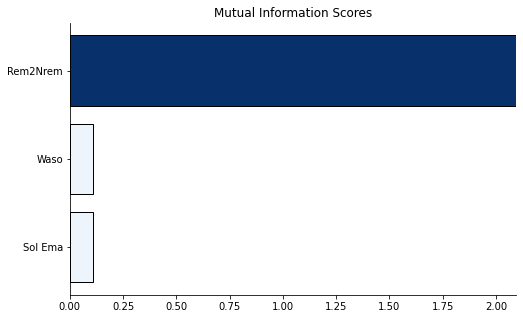

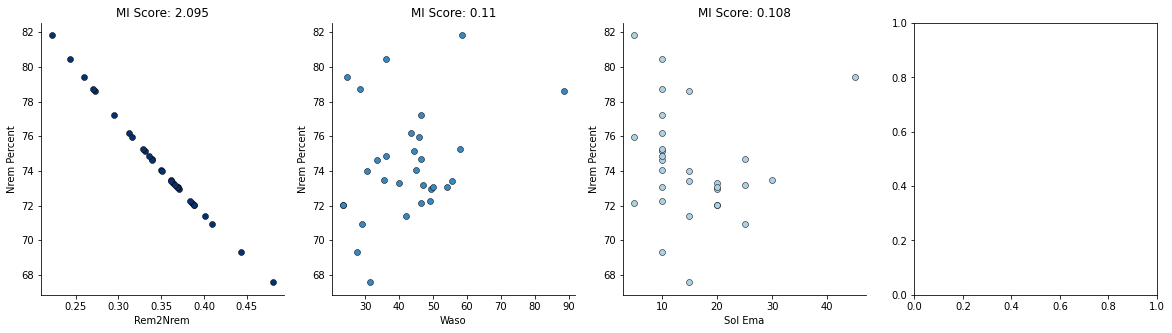

Participant: 34 - Number of Datapoints: 30


In [59]:
datasets = [features_ieq_no_no2, features_srsm]
#datasets = [features_activity]
dataset_names = ["IEQ - NO2","IEQ - No NO2","Mood","Self-Report Sleep","Activity","Environment and Experiences"]
vars_to_omit = [var for var in labels.columns if var.endswith("count") or var.endswith("minutes")] + ["light_percent","deep_percent","wake_percent","tst_ema","efficiency_normalized","efficiency_low"]
target_labels = ["nrem_percent","rem_percent","rem2nrem_percent","tst_fb","efficiency"]
# looping through feature sets and targets
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    for pt in temp["redcap"].unique():
        temp_by_pt = temp[temp["redcap"] == pt]
        if len(temp_by_pt) > 29:
            if fe.check_features_against_targets(temp_by_pt,target_labels,features_to_show=4,tolerance=0.1):
                print(f"Participant: {int(pt)} - Number of Datapoints: {len(temp_by_pt)}")

## Clustering
We can see if grouping various components of the features results in a stronger relationship. There are two main ideas in this section:
1. **Grouping**: We can use traits of the participant/environment to group the data into different subsets in addition to looking at things like low versus elevated levels of the feature (i.e. low vs high mean pollutant concentration, low versus high activity levels, etc.)
2. **Clustering**: By clustering into different subsections, perhaps we can idenify subgroups that are not apparent from the raw data.

### Grouping
We start with some simply grouping data by feature, trait, or value.

#### Negligible Changes in Concentration 
For each measurement on the BEVO Beacon, we have a `delta` summary statistic to see what the difference between the minimum and maximum concentration was during that particular evening. For nights with no _considerable_ change, we might say the participant was accustomed to that concentration so their sleep would not have been affected. Here we examine that more closely.

In [60]:
target_labels = ["nrem_percent","rem_percent","rem2nrem_percent","tst_fb","efficiency","efficiency_normalized"]
# no2
delta_ieq_high_no2 = features_ieq_no2[[column for column in features_ieq_no2.columns if column.endswith("delta") or column in target_labels]]
delta_ieq_high_no2.dropna(subset=["no2_delta"],inplace=True)
hist, bin_edges = np.histogram(delta_ieq_high_no2["no2_delta"],bins=10)
for i, val in enumerate(hist):
    print(f"{round(bin_edges[i],2)}-{round(bin_edges[i+1],2)}: {val}", end="\t")


0.0-0.14: 88	0.14-0.27: 29	0.27-0.41: 6	0.41-0.55: 8	0.55-0.69: 2	0.69-0.82: 0	0.82-0.96: 0	0.96-1.1: 0	1.1-1.23: 0	1.23-1.37: 1	

Based on the numbers above, a considerable amount of nights see a difference of only 0.2 or less. If we drop these values from the dataset, perhaps a more clean relationship will appear.

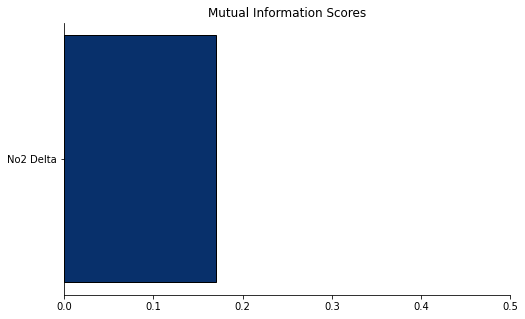

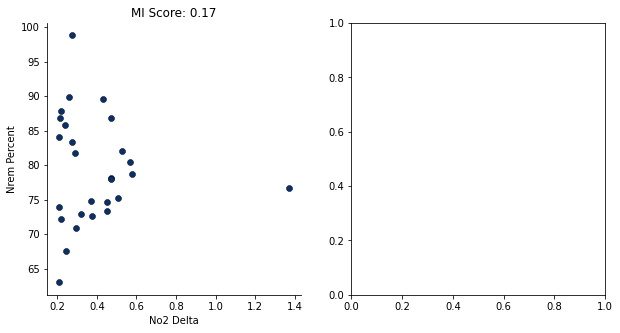

True

In [61]:
df_to_test = delta_ieq_high_no2[delta_ieq_high_no2["no2_delta"] > 0.2]
fe.check_features_against_targets(df_to_test,target_labels,features_to_show=2,tolerance=0.0)

<div class="alert alert-block alert-danger">
    
Removing low changes in `no2_delta` **weakened** the relationship.
    
</div>

tvoc: 0.0-315.8: 248	315.8-631.59: 20	631.59-947.39: 5	947.39-1263.18: 6	1263.18-1578.98: 0	1578.98-1894.77: 0	1894.77-2210.57: 0	2210.57-2526.36: 0	2526.36-2842.16: 0	2842.16-3157.95: 1	

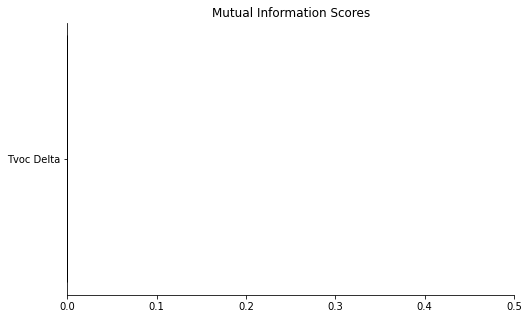

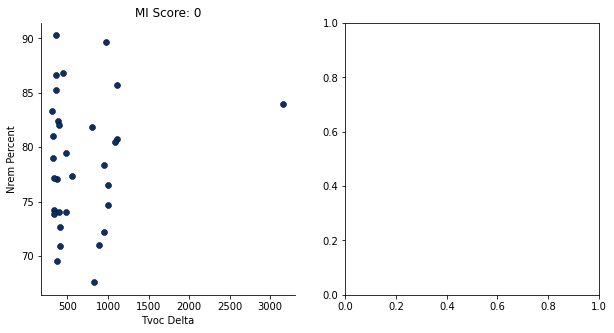

lux: 0.0-169.7: 275	169.7-339.41: 0	339.41-509.11: 0	509.11-678.81: 0	678.81-848.52: 1	848.52-1018.22: 2	1018.22-1187.92: 0	1187.92-1357.63: 1	1357.63-1527.33: 0	1527.33-1697.04: 1	

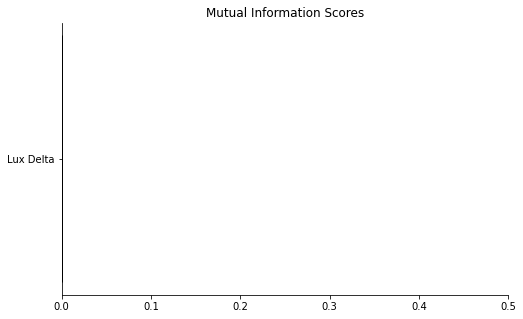

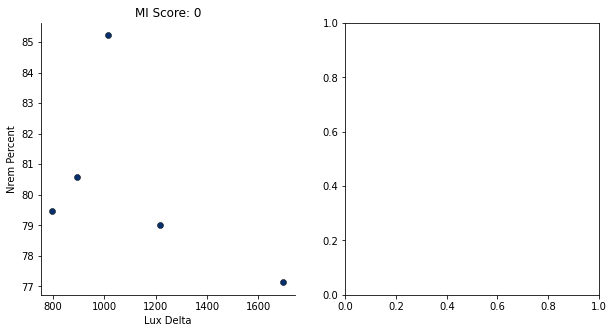

co: 0.0-1.72: 234	1.72-3.44: 25	3.44-5.17: 12	5.17-6.89: 2	6.89-8.61: 0	8.61-10.33: 0	10.33-12.05: 0	12.05-13.78: 0	13.78-15.5: 0	15.5-17.22: 1	

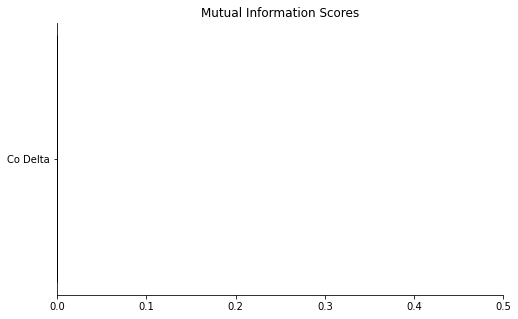

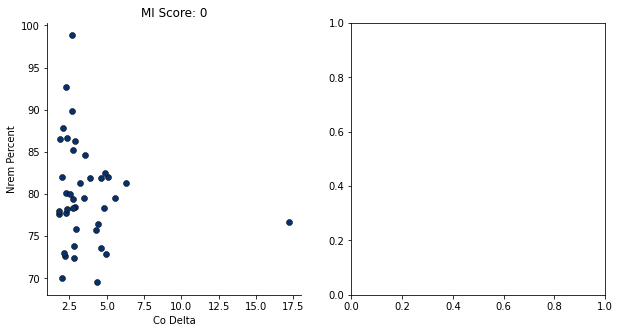

co2: 0.0-92.12: 61	92.12-184.23: 108	184.23-276.35: 57	276.35-368.47: 29	368.47-460.58: 9	460.58-552.7: 3	552.7-644.81: 3	644.81-736.93: 4	736.93-829.05: 4	829.05-921.16: 2	

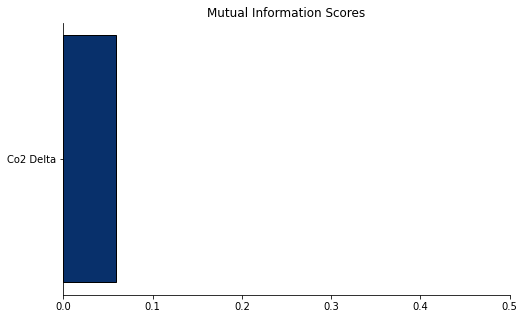

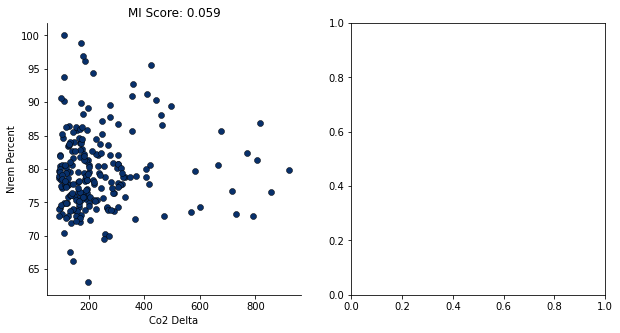

pm2p5: 0.0-11.04: 209	11.04-22.08: 35	22.08-33.12: 11	33.12-44.16: 4	44.16-55.2: 1	55.2-66.24: 2	66.24-77.29: 2	77.29-88.33: 1	88.33-99.37: 1	99.37-110.41: 1	

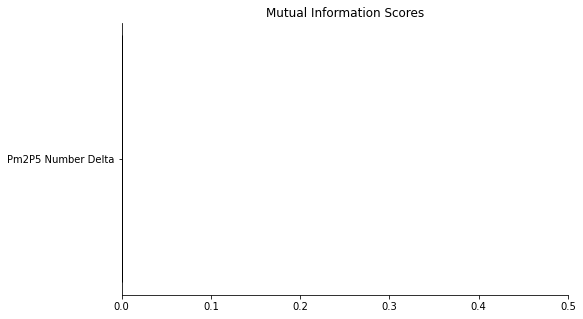

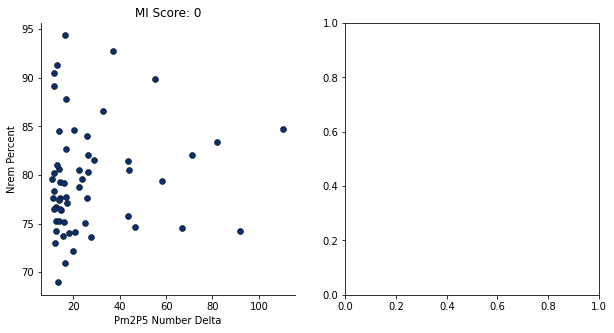

pm2p5: 0.0-9.26: 237	9.26-18.52: 16	18.52-27.79: 3	27.79-37.05: 0	37.05-46.31: 0	46.31-55.57: 1	55.57-64.83: 0	64.83-74.09: 2	74.09-83.36: 0	83.36-92.62: 1	

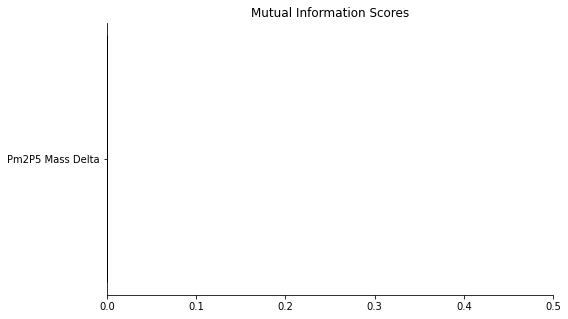

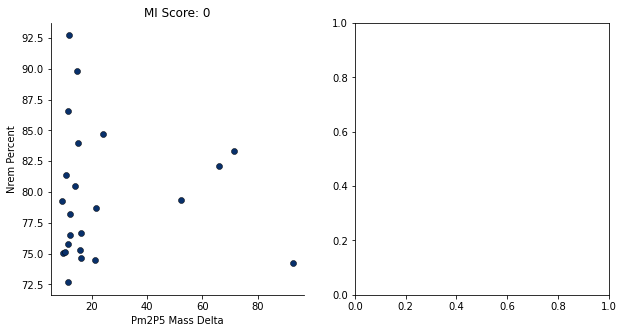

temperature: 0.0-0.43: 37	0.43-0.87: 31	0.87-1.3: 118	1.3-1.73: 20	1.73-2.17: 52	2.17-2.6: 10	2.6-3.03: 9	3.03-3.47: 1	3.47-3.9: 1	3.9-4.33: 1	

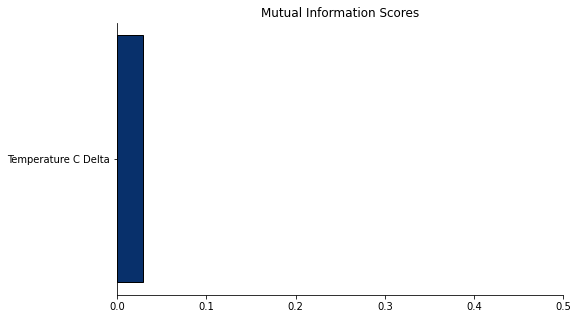

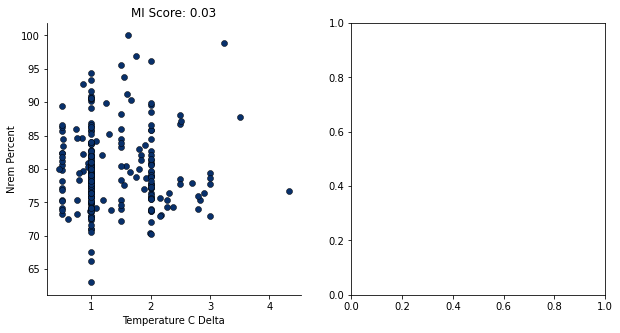

rh: 0.0-1.57: 56	1.57-3.14: 115	3.14-4.72: 62	4.72-6.29: 20	6.29-7.86: 11	7.86-9.44: 10	9.44-11.01: 4	11.01-12.58: 1	12.58-14.15: 0	14.15-15.72: 1	

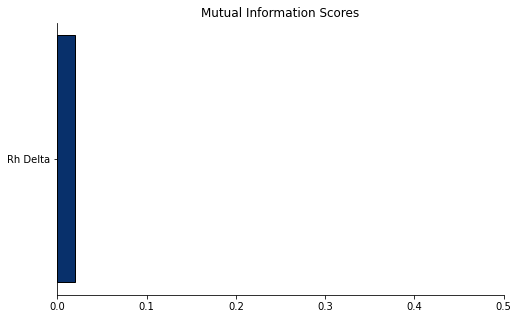

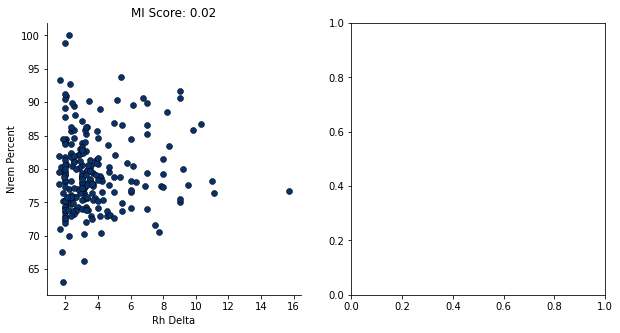

In [62]:
# remaining pollutants
delta_ieq_high = features_ieq_no_no2[[column for column in features_ieq_no_no2.columns if column.endswith("delta") or column in target_labels]]
for column in features_ieq_no_no2:
    if column.endswith("delta"):
        print(column.split("_")[0], end=": ")
        temp = delta_ieq_high.dropna(subset=[column])
        hist, bin_edges = np.histogram(temp[column],bins=10)
        for i, val in enumerate(hist):
            print(f"{round(bin_edges[i],2)}-{round(bin_edges[i+1],2)}: {val}", end="\t")
        df_to_test = temp[temp[column] > bin_edges[1]]
        good_cols = target_labels+[column]
        df_to_test = df_to_test[[c for c in df_to_test.columns if c in good_cols]]
        fe.check_features_against_targets(df_to_test,target_labels,features_to_show=2,tolerance=0.0)

<div class="alert alert-block alert-warning">
    
Removing low changes in `*_delta` variables did not seem to show any improvements in the relationships.
    
</div>

#### Building Type
Data from the REDCap survey can be used to group individual data points to see if there is any relationship.

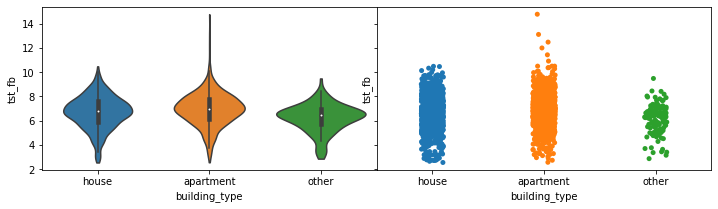

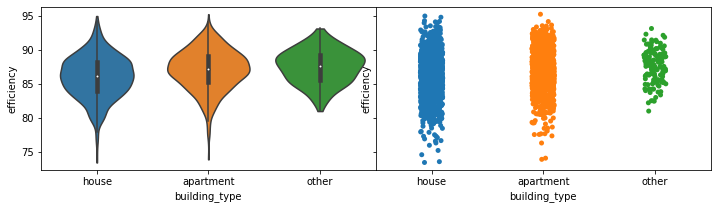

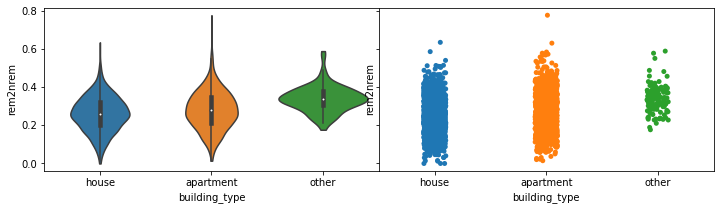

In [64]:
for metric in ["tst_fb","efficiency","rem2nrem"]:
    fig, ax = plt.subplots(1,2,figsize=(12,3),sharey=True)
    sns.violinplot(x="building_type",y=metric,cut=0,data=features_env,ax=ax[0])
    sns.stripplot(x="building_type",y=metric,data=features_env,ax=ax[1])
    plt.subplots_adjust(wspace=0)
    plt.show()
    plt.close()

In [65]:
def plot_joyplot(df, features, target):
    """
    Plots a joyplot of the distribution of the target variable for the given features.
    """
    df_expanded = df.melt(id_vars=target,value_vars=features,var_name="feature",value_name='represented')
    df_expanded = df_expanded[(df_expanded["represented"] > 0) & df_expanded[target] > 0]
    labels = []
    df_expanded.sort_values(by="feature",inplace=True)
    for f in df_expanded["feature"].unique():
        temp = df[df[f] == 1]
        labels.append(f"{f.replace('_',' ').title()} - {len(temp)}")
        
    fig, ax = joyplot(data=df_expanded,by="feature",column=target,
                kind='kde',overlap=1,ylim='own',alpha=0.75,colormap=cm.Blues_r,figsize=(12,6),labels=labels)

    plt.show()
    plt.close()
    
    return df_expanded

### Feature(s): Pollution Profiles
It is also worthwhile to consider evenings with low, normal, and elevated concentrations of each pollutant. Low and normal concentration profiles are likely to have less of an effect on sleep parameters while elevated concentrations are what we are _hoping_ affects sleep quality. We will base the clusters off of the **median** concentration experienced during a given evening.

In [66]:
datasets = [features_ieq]
for dataset in datasets:
    summary_stat = "median"
    for pollutant in ["pm2p5_mass","pm2p5_number","co","co2","no2","tvoc"]:
        dataset[f"{pollutant}_{summary_stat}"].fillna(-100,inplace=True) # temporarily filling nans to run kmeans
        if -100 in dataset[f"{pollutant}_{summary_stat}"].unique():
            kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
        else:
            kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
            
        dataset[f"{pollutant}_{summary_stat}_profile"] = kmeans.fit_predict(np.array(dataset[f"{pollutant}_{summary_stat}"]).reshape(-1, 1))
    dataset.replace(-100,np.nan,inplace=True) # replacing artificial values with nan

Now we can see if clustering the pollution profiles created any noticeable differences in sleep metrics.

pm2p5 mass


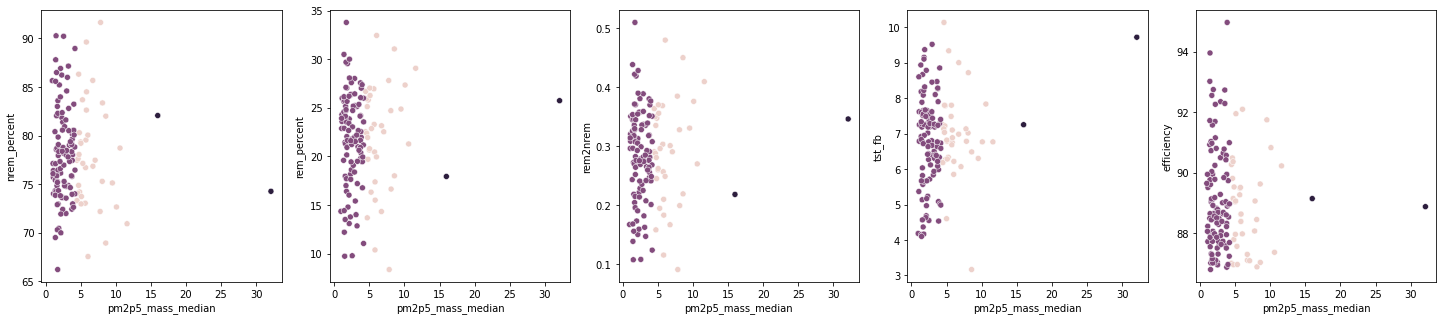

pm2p5 number


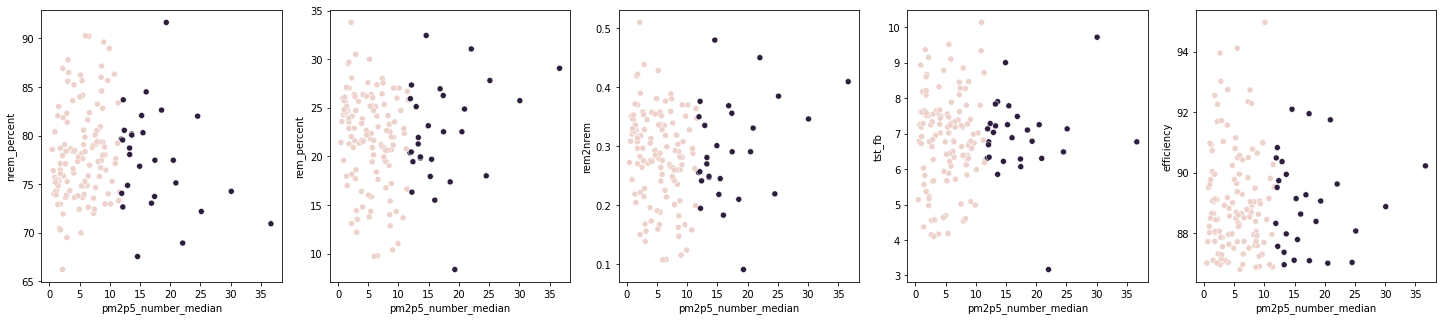

co


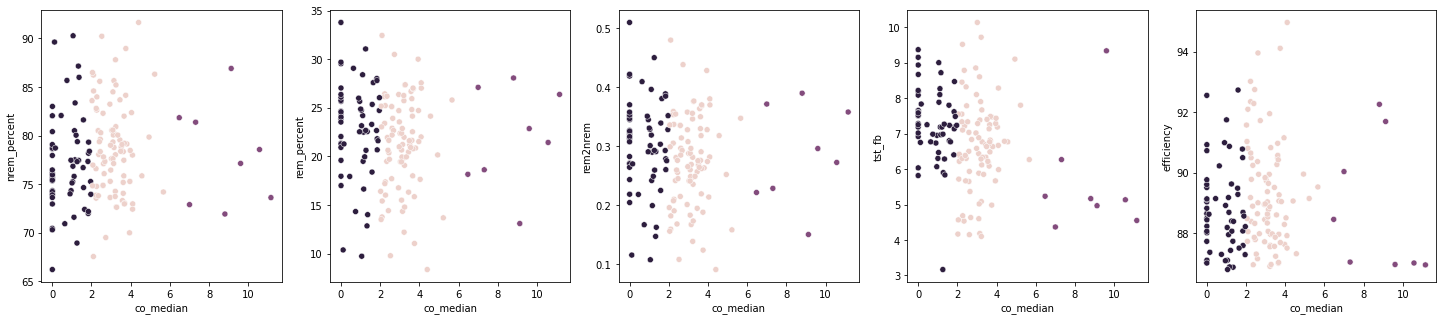

co2


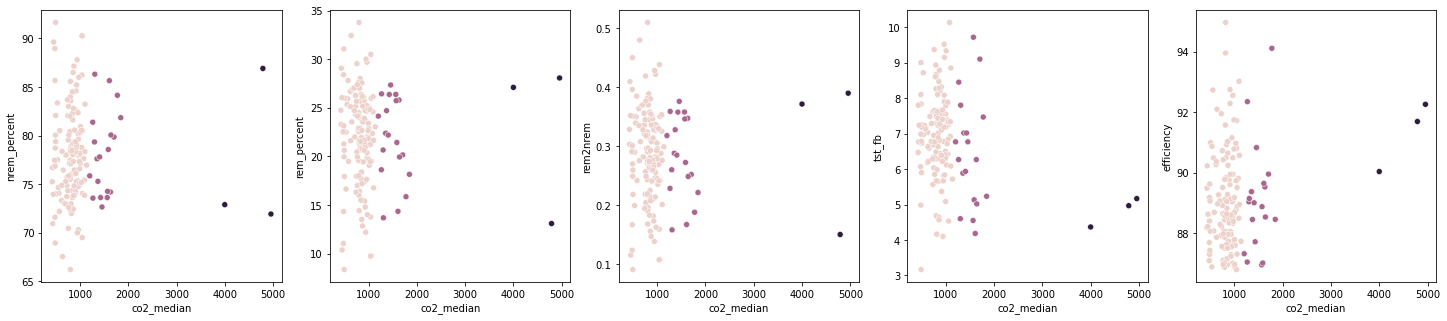

no2


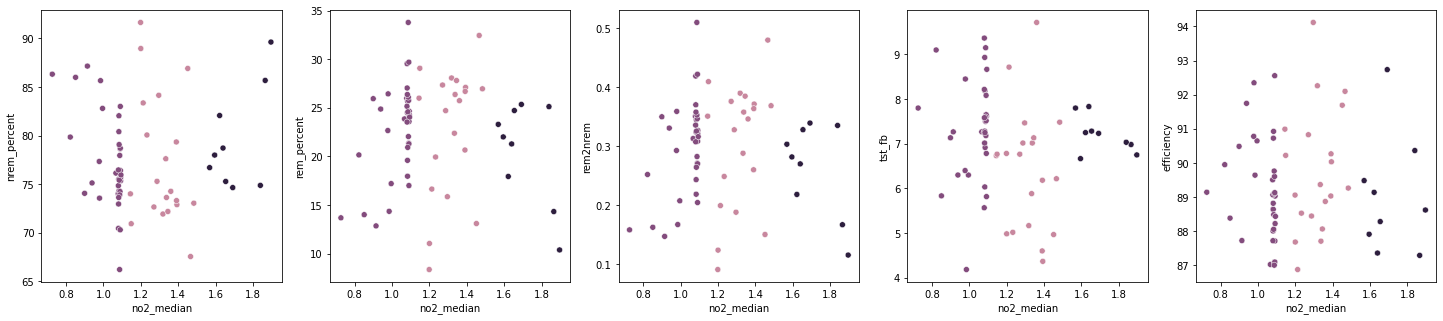

tvoc


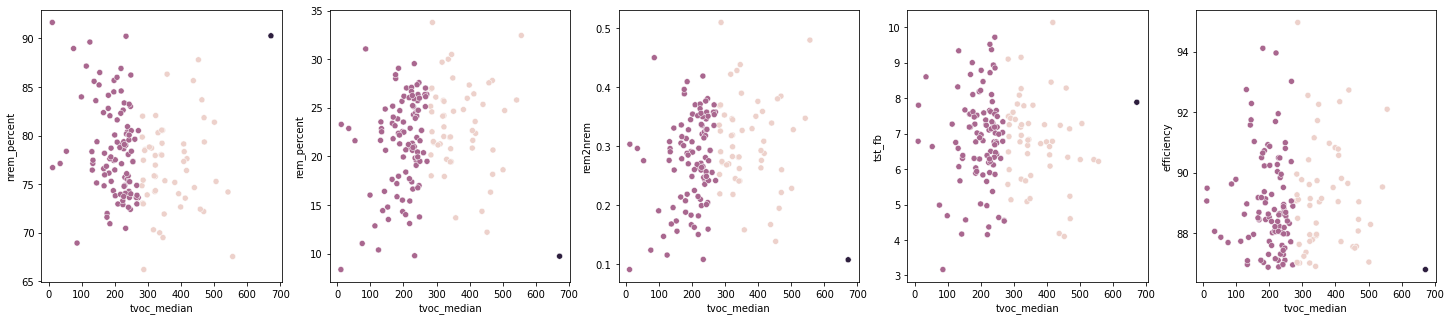

In [67]:
target_labels = ["nrem_percent","rem_percent","rem2nrem","tst_fb","efficiency"]
temp = features_ieq.copy()
temp = temp[temp["efficiency_low"] == 0]
for pollutant in ["pm2p5_mass","pm2p5_number","co","co2","no2","tvoc"]:
    print(pollutant.replace("_"," "))
    fig, axes = plt.subplots(1,len(target_labels),figsize=(5*len(target_labels),5))
    for target_label, ax in zip(target_labels,axes.flat):
        df_to_plot = temp.dropna(subset=[f"{pollutant}_{summary_stat}"],axis=0)
        sns.scatterplot(x=f"{pollutant}_{summary_stat}",y=target_label,hue=f"{pollutant}_{summary_stat}_profile",data=temp,legend=False,ax=ax)
        
    plt.show()
    plt.close()

<div class="alert alert-block alert-info">
    
There do not seem to be any strong correlations between sleep **median** pollutant concentration and any of the Fitbit-measured sleep metrics. 
    
</div>

<a id="pca"></a>

## Principal Component Analysis
The following cells use Principal Component Analysis (PCA) to help identify relationships between features, create features in the datasets, and show any outlying data points.

In [83]:
from sklearn.decomposition import PCA
from features.principal_component_analysis import pca
from features.feature_engineering import fe

### Idenfitying Relationships
We start using PCA by analyzing relationships between features. We can look at each of the feature sets to see which variables have some sort of correlation.

Below we define a function to grab the features we are interested in and scale them for a better analysis.

In [69]:
def features_for_pca(df, feature_labels, scale=True):
    """
    Collects features from the original dataframe and scales them
    
    Inputs:
    - df: dataframe with features
    - features_labels: list of strings specifying the columns to pull from df
    - scale: whether or not to scale the values
    
    Returns a dataframe with scaled features
    """
    X = df.copy()
    X = X.loc[:, feature_labels]
    if scale:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        
    return X

We will also create a function that performs the PCA for us and returns a nicely formatted dataframe.

In [70]:
def run_pca(X):
    """
    Take a feature set, performs PCA, and returns the formatted results
    
    Returns a dataframe of the formatted results from PCA
    """
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return loadings, pca

And lastly two functions to help visualize the relationships by.

In [71]:
def visualize_pca(loadings, pca):
    """
    Plots a bar chart, cumulative plot, and heatmap of the pca loadings 
    
    Returns void
    """
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    my_cmap = plt.get_cmap("Blues")
    rescale = lambda y: y / np.max(y)
    evr = pca.explained_variance_ratio_
    axes[0].bar(grid, evr, edgecolor="black",color=my_cmap(rescale(evr)))
    axes[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axes[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", linewidth=2,color="black")
    axes[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    for ax in axes.flat[:2]:
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        
    sns.heatmap(loadings,vmin=-1,vmax=1,annot=True,fmt=".2f",square=True,
                linecolor="black",linewidth=1,cmap="coolwarm_r",
                yticklabels=[var.replace("_"," ").title() for var in loadings.index],cbar_kws={"ticks":[-1,-0.5,0,0.5,1]},ax=axes[2])
    plt.yticks(rotation=0)
    
    plt.show()
    plt.close()

#### Self-Report Mood
Mood is only reported on a four-point scale so perhaps PCA is not applicable in this case, but we can still check.

In [72]:
features_mood.columns[22:]

Index(['rem2nrem_percent', 'efficiency_normalized', 'efficiency_low'], dtype='object')

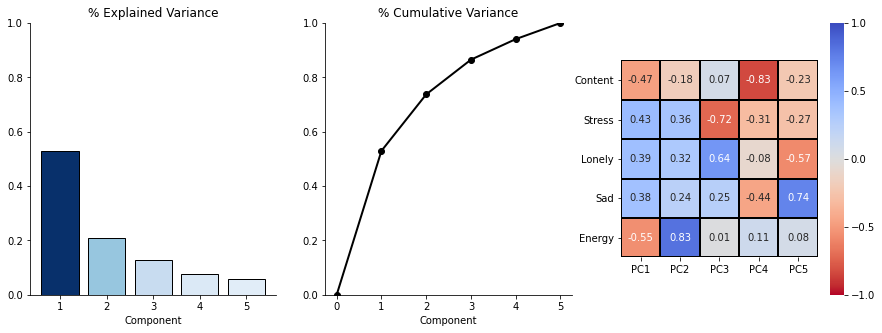

In [73]:
# getting data
X = features_for_pca(features_mood, feature_labels=['content', 'stress', 'lonely', 'sad', 'energy'], scale=False) # No need to scale since our values are all on the same scale already
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)

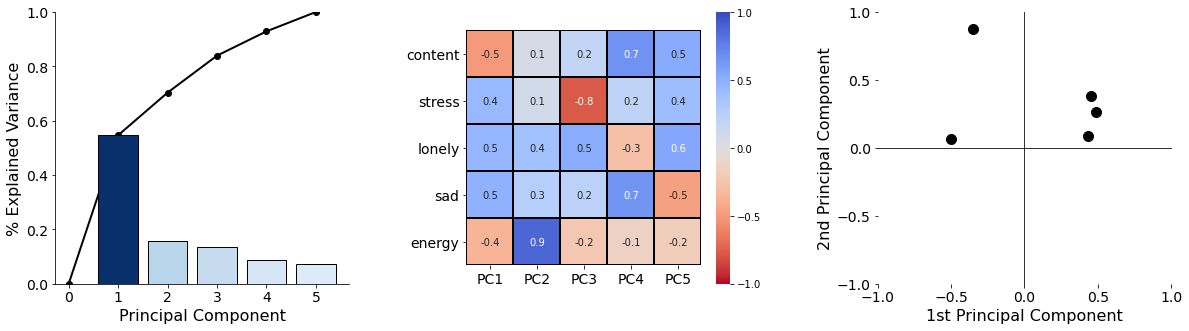

(<Figure size 1440x360 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae5288e278>)

In [81]:
mood_pca = pca()
mood_pca.collect_features(features_mood, feature_labels=['content', 'stress', 'lonely', 'sad', 'energy'])
mood_pca.run()
mood_pca.visualize()

<div class="alert alert-block alert-info">

**PC1**: Participants how are sad, lonely, and stressed with little energy and contentment - almost a positive vs negative mood.

##### Mutual Information Scores
Might as well compare PC1 to all sleep metrics from Fitbit.

In [84]:
mood_fe = fe()
for target in ["rem2nrem","tst_fb","efficiency"]:
    print(f"{target.replace('_',' ').upper()}")
    print(mood_fe.get_mi_scores(mood_pca.X_pca,features_mood.loc[:,target]))

REM2NREM
PC3    0.004763
PC5    0.000276
PC4    0.000000
PC2    0.000000
PC1    0.000000
Name: MI Scores, dtype: float64
TST FB
PC3    0.085383
PC2    0.026773
PC1    0.015848
PC4    0.001656
PC5    0.000000
Name: MI Scores, dtype: float64
EFFICIENCY
PC2    0.007053
PC5    0.000000
PC4    0.000000
PC3    0.000000
PC1    0.000000
Name: MI Scores, dtype: float64


#### Self-Report Sleep

In [74]:
features_srsm.columns[22:]

Index(['efficiency_normalized', 'efficiency_low'], dtype='object')

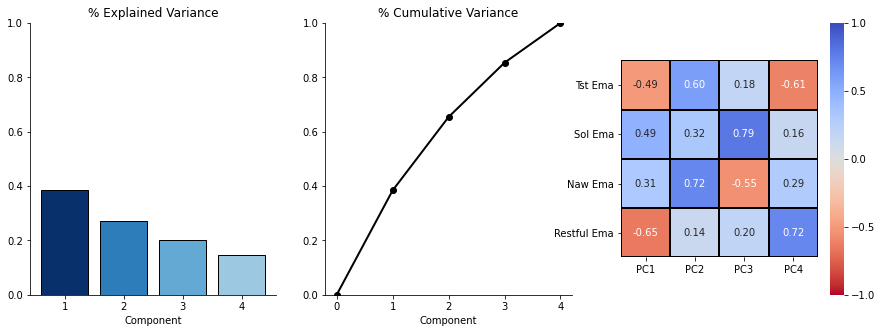

In [75]:
# getting data
X = features_for_pca(features_srsm, feature_labels=['tst_ema', 'sol_ema', 'naw_ema', 'restful_ema'], scale=True)
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)

#### Fitbit Activity

In [76]:
features_activity.columns[22:]

Index(['light_percent', 'wake_percent', 'rem2nrem_percent',
       'efficiency_normalized', 'efficiency_low'],
      dtype='object')

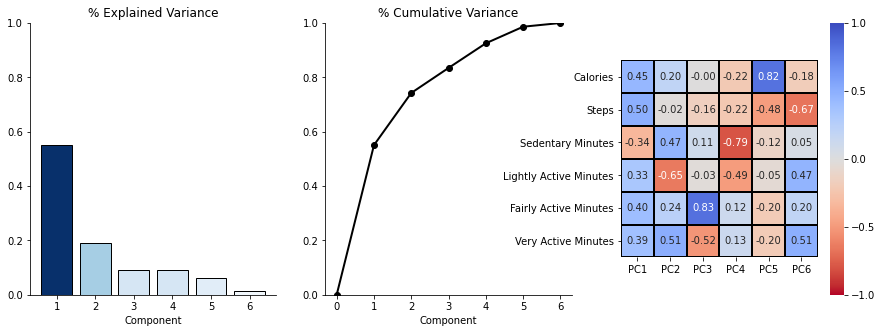

In [77]:
# getting data
X = features_for_pca(features_activity, feature_labels=['calories', 'steps', 'sedentary_minutes', 'lightly_active_minutes','fairly_active_minutes', 'very_active_minutes'], scale=True)
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)